# ====================================================
#  Import Libraries
# ====================================================

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
import torch
import sklearn
import warnings
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from tqdm import tqdm
import transformers
from transformers import pipeline
import xgboost as xgb
from scipy.stats import pearsonr
import language_tool_python
import textstat
import subprocess
import time
import glob
from contextlib import contextmanager
import tempfile
import shutil

# --- Configuration ---
ENABLE_TUNING = False # Set to True to run GridSearchCV (can be time-consuming)
CACHE_DIR = "cache"   # Directory to store processed features
BASE_DIR = "Dataset"  # Main dataset directory
SR_AUDIO_FEATURES = 8000 # Sample rate for general audio features
SR_ASR = 16000         # Sample rate required by Whisper ASR
ASR_CHUNK_DURATION_S = 30.0 # Duration for Whisper chunking
ASR_STRIDE_DURATION_S = 5.0  # Overlap for Whisper chunking (optional)
CV_FOLDS = 5             # Number of folds for cross-validation
FEATURE_SELECTION_K = 30 # Number of features to select with SelectKBest

# --- Setup ---
print("--- Initializing Script ---")

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    print("NLTK resources found.")
except nltk.downloader.DownloadError:
    print("Downloading NLTK resources (punkt, averaged_perceptron_tagger)...")
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('averaged_perceptron_tagger', quiet=True)
        print("NLTK resources downloaded successfully.")
    except Exception as e:
        print(f"[ERROR] Failed to download NLTK resources: {e}")
        print("Text feature extraction might fail. Please check your internet connection or NLTK setup.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create cache directory if it doesn't exist
os.makedirs(CACHE_DIR, exist_ok=True)
print(f"Cache directory: '{CACHE_DIR}'")

# Temporary directory context manager
@contextmanager
def temporary_directory():
    """Context manager for creating and cleaning up a temporary directory."""
    temp_dir = tempfile.mkdtemp()
    # print(f"[DEBUG] Created temporary directory: {temp_dir}") # Optional debug info
    try:
        yield temp_dir
    finally:
        # print(f"[DEBUG] Removing temporary directory: {temp_dir}") # Optional debug info
        shutil.rmtree(temp_dir, ignore_errors=True)

--- Initializing Script ---
NLTK resources found.
Using device: cpu
Cache directory: 'cache'


# ====================================================
# 1. Helper Functions
# ====================================================

In [2]:

def check_ffmpeg():
    """Check if ffmpeg is available in the system PATH."""
    try:
        # Use subprocess.run for modern Python, capturing output and checking return code
        result = subprocess.run(["ffmpeg", "-version"], check=True, capture_output=True, text=True, timeout=5)
        print("FFmpeg found and accessible.")
        return True
    except FileNotFoundError:
        print("[ERROR] FFmpeg not found. Install FFmpeg and ensure it's in your system PATH.")
        print("See: https://ffmpeg.org/download.html")
        print("Transcription features will be skipped.")
        return False
    except subprocess.TimeoutExpired:
        print("[ERROR] FFmpeg check timed out. There might be an issue with FFmpeg.")
        return False
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] FFmpeg check failed with an error: {e}")
        print(f"Stderr: {e.stderr}")
        return False
    except Exception as e:
        print(f"[ERROR] An unexpected error occurred during FFmpeg check: {e}")
        return False


# ====================================================
# 2. Data Loading and Exploration
# ====================================================


--- Loading Data and Initial Exploration ---
Checking required paths...
All required paths found.
Training audio files found: 444
Test audio files found: 204
Loading CSV data...
Training data shape: (444, 2)
Testing data shape: (204, 1)
Sample submission shape: (204, 2)

Sample of training data (first 5 rows):

        file_name  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0

Plotting distribution of grammar scores...


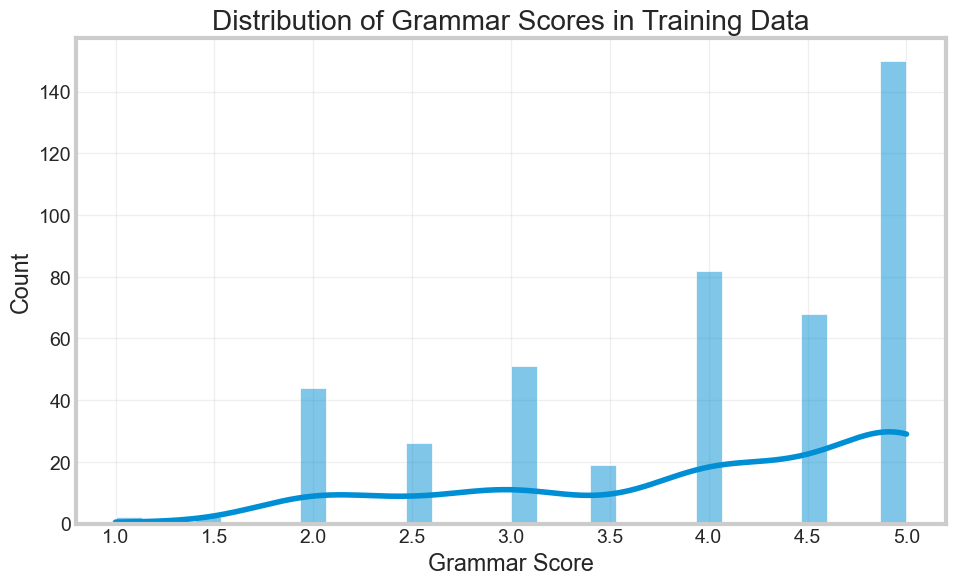


Statistics of grammar scores:

count    444.000000
mean       3.967342
std        1.048784
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000


In [3]:

print("\n--- Loading Data and Initial Exploration ---")

# Define paths
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TEST_CSV = os.path.join(BASE_DIR, "test.csv")
SAMPLE_SUBMISSION_CSV = os.path.join(BASE_DIR, "sample_submission.csv")
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "audios", "train")
TEST_AUDIO_DIR = os.path.join(BASE_DIR, "audios", "test")

# Verify paths exist
print("Checking required paths...")
paths_ok = True
for path in [BASE_DIR, TRAIN_CSV, TEST_CSV, SAMPLE_SUBMISSION_CSV, TRAIN_AUDIO_DIR, TEST_AUDIO_DIR]:
    if not os.path.exists(path):
        print(f"[ERROR] Path not found: {path}")
        paths_ok = False
if not paths_ok:
    raise FileNotFoundError("One or more required paths not found. Please check your directory structure.")
else:
    print("All required paths found.")

# Print directory contents count
try:
    print(f"Training audio files found: {len(os.listdir(TRAIN_AUDIO_DIR))}")
    print(f"Test audio files found: {len(os.listdir(TEST_AUDIO_DIR))}")
except FileNotFoundError as e:
    print(f"[ERROR] Could not list audio directory contents: {e}")
    raise

# Load data
print("Loading CSV data...")
try:
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    sample_submission = pd.read_csv(SAMPLE_SUBMISSION_CSV)
except FileNotFoundError as e:
    print(f"[ERROR] Failed to load CSV file: {e}")
    raise
except Exception as e:
    print(f"[ERROR] An unexpected error occurred while loading CSV data: {e}")
    raise


print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")


# Verify expected columns
expected_train_cols = {'file_name', 'label'}
expected_test_cols = {'file_name'}
if not expected_train_cols.issubset(train_df.columns):
    print(f"[ERROR] Train CSV missing expected columns: {expected_train_cols - set(train_df.columns)}")
    raise ValueError("Train CSV missing expected columns")
if not expected_test_cols.issubset(test_df.columns):
    print(f"[ERROR] Test CSV missing expected columns: {expected_test_cols - set(test_df.columns)}")
    raise ValueError("Test CSV missing expected columns")

# Display first few rows of training data
print("\nSample of training data (first 5 rows):")
print(f"\n{train_df.head().to_string()}")

# Analyze distribution of grammar scores
print("\nPlotting distribution of grammar scores...")
try:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_df['label'], bins=30, kde=True)
    plt.title('Distribution of Grammar Scores in Training Data')
    plt.xlabel('Grammar Score')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.close()
except Exception as e:
    print(f"[ERROR] Failed to plot grammar score distribution: {e}")

print("\nStatistics of grammar scores:")
print(f"\n{train_df['label'].describe().to_string()}")

# Verify audio files exist (optional but recommended)
def verify_audio_files(df, audio_dir):
    """Checks if audio files listed in the dataframe exist in the specified directory."""
    missing_files = []
    found_count = 0
    print(f"Verifying audio files listed in CSV against directory: {audio_dir}...")
    for file_name in tqdm(df['file_name'], desc=f"Checking {os.path.basename(audio_dir)} files"):
        file_path = os.path.join(audio_dir, file_name)
        if not os.path.exists(file_path):
            missing_files.append(file_name)
        else:
            found_count += 1
    print(f"Found {found_count} matching audio files in {audio_dir} based on CSV.")
    if missing_files:
        print(f"[WARNING] Missing {len(missing_files)} audio files listed in CSV (examples): {missing_files[:5]}...")
    if found_count != len(df):
        print(f"[WARNING] Number of files found ({found_count}) does not match CSV rows ({len(df)}).")
    return missing_files



# ====================================================
# 3. Audio Processing Functions
# ====================================================

In [4]:

print("\n--- Defining Audio Processing Functions ---")

def load_audio(file_path, sr=None):
    """
    Load audio file using librosa. Loads native sample rate first, then resamples if sr is specified.
    Args:
        file_path (str): Path to the audio file.
        sr (int, optional): Target sample rate. If None, loads native sample rate. Defaults to None.
    Returns:
        tuple: (numpy.ndarray: audio time series, int: sample rate) or (None, None) on failure.
    """
    try:
        # Load with native sample rate
        y, sr_native = librosa.load(file_path, sr=None)

        # Resample if a target sr is provided and different from native
        if sr is not None and sr_native != sr:
            y = librosa.resample(y=y, orig_sr=sr_native, target_sr=sr)
            current_sr = sr
            # print(f"[DEBUG] Resampled {os.path.basename(file_path)} from {sr_native}Hz to {sr}Hz.")
        else:
            current_sr = sr_native # Keep native if no target sr or if it matches native

        # print(f"Loaded audio: {os.path.basename(file_path)}, SR={current_sr}Hz, Duration={librosa.get_duration(y=y, sr=current_sr):.2f}s") # Can be verbose
        return y, current_sr
    except FileNotFoundError:
        print(f"[ERROR] Audio file not found: {file_path}")
        return None, None
    except Exception as e:
        print(f"[ERROR] Error loading audio {file_path}: {e}")
        return None, None

def extract_audio_features(y, sr):
    """
    Extract various audio features from an audio time series.
    Args:
        y (np.ndarray): Audio time series.
        sr (int): Sample rate of the audio.
    Returns:
        dict: Dictionary containing extracted audio features, or None on failure.
    """
    if y is None or len(y) == 0 or sr is None:
        print("[WARNING] Invalid audio data (None, empty, or sr=None) passed to extract_audio_features.")
        return None # Cannot extract features from invalid data

    features = {}
    duration = librosa.get_duration(y=y, sr=sr)
    features['duration'] = duration

    # Basic check for near-silent audio which can cause issues
    if np.max(np.abs(y)) < 1e-5:
        print(f"[WARNING] Audio seems near-silent (max abs value < 1e-5). Features might be zero or unstable.")
        # Return zeros for key features or handle as needed
        features['zero_crossing_rate'] = 0.0
        features['rms'] = 0.0
        features['spectral_centroid'] = 0.0
        features['spectral_bandwidth'] = 0.0
        features['spectral_rolloff'] = 0.0
        mfcc_dim = 6 # Must match n_mfcc below
        for i in range(mfcc_dim):
             features[f'mfcc_{i+1}_mean'] = 0.0
             features[f'mfcc_{i+1}_std'] = 0.0
        features['onset_strength_mean'] = 0.0
        features['tempo'] = 0.0
        features['pitch_mean'] = 0.0
        features['speaking_rate'] = 0.0
        return features # Return features with zeros

    try:
        # Basic features
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y=y))
        features['rms'] = np.mean(librosa.feature.rms(y=y))

        # Spectral features
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        # Spectral rolloff can sometimes be unstable or less informative, optional
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

        # MFCCs (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=6) # Using 6 MFCCs
        for i, mfcc_coeffs in enumerate(mfccs):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfcc_coeffs)
            features[f'mfcc_{i+1}_std'] = np.std(mfcc_coeffs)

        # Temporal features: Onset Strength
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        features['onset_strength_mean'] = np.mean(onset_env)

        # Tempo Estimation
        try:
            # Estimate tempo from onset envelope
            tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            # beat_track can return an array if multiple tempos detected, take the first/most likely
            features['tempo'] = tempo if np.isscalar(tempo) else (tempo[0] if len(tempo) > 0 else 0)
        except librosa.util.exceptions.ParameterError as pe:
            print(f"[WARNING] Could not compute tempo: {pe}. Setting tempo to 0.")
            features['tempo'] = 0
        except Exception as tempo_e: # Catch other potential errors
            print(f"[WARNING] Unexpected error computing tempo: {tempo_e}. Setting tempo to 0.")
            features['tempo'] = 0


       
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        # Filter pitches where magnitude is non-zero and average them
        valid_pitch_frames = pitches[magnitudes > 0]
        pitch_mean = np.mean(valid_pitch_frames[valid_pitch_frames > 0]) if np.any(valid_pitch_frames > 0) else 0
        features['pitch_mean'] = pitch_mean

        # Speaking Rate Estimation (simple syllable approximation via RMS peaks)
        hop_length = 512
        frame_length = 1024 # Smaller frame for better temporal resolution of peaks
        rms_frames = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        # Peak picking parameters might need tuning based on speech characteristics
        peaks = librosa.util.peak_pick(rms_frames, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.05, wait=10) # Adjusted delta/wait
        if duration > 0.1: # Avoid division by zero for very short files
             # Number of peaks per second (approximate syllables/sec)
             features['speaking_rate'] = len(peaks) / duration
        else:
             features['speaking_rate'] = 0

    except Exception as e:
        print(f"[ERROR] Failed during audio feature extraction: {e}")
       
        return None

    # Fill NaNs just in case any calculation resulted in NaN (e.g., tempo on silence)
    return pd.Series(features).fillna(0.0).to_dict()


--- Defining Audio Processing Functions ---


# ====================================================
# 4. Speech-to-Text Functions
# ====================================================

In [5]:

print("\n--- Initializing Speech Recognition Model ---")

# Initialize Whisper ASR model
asr = None
ffmpeg_path_explicit = None # Set this if ffmpeg is not in PATH, e.g., "/path/to/ffmpeg"
try:
    # Check FFmpeg availability *before* loading the model if transcription is intended
    ffmpeg_available = check_ffmpeg()
    if not ffmpeg_available:
        print("[INFO] FFmpeg check failed. ASR pipeline will not be initialized.")
    else:
        print(f"Loading Whisper ASR model (openai/whisper-tiny) onto device: {device}...")
       
        model_kwargs = {}

        asr = pipeline(
            "automatic-speech-recognition",
            model="openai/whisper-tiny", # Using tiny for speed, consider base or small for better accuracy
            device=device,
            model_kwargs=model_kwargs
        )
        # Setting prefix tokens might help constrain output language, although Whisper often detects English well
        asr.tokenizer.set_prefix_tokens(language="en", task="transcribe")
        print("Whisper ASR model loaded successfully.")

except ImportError as ie:
     print(f"[ERROR] Transformers library or its dependencies not found: {ie}")
     print("Please install transformers: pip install transformers torch")
     asr = None
except Exception as e:
    print(f"[ERROR] Failed to load Whisper model: {e}")
    print("Transcription will not be available.")
    asr = None


def preprocess_audio_for_asr(file_path, target_sr=SR_ASR):
    """
    Preprocesses audio specifically for ASR: Loads, resamples to target_sr, optionally trims silence.
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sample rate for ASR model (e.g., 16000 for Whisper).
    Returns:
        tuple: (numpy.ndarray audio time series, int sample rate, float duration, float RMS) or (None, target_sr, 0, 0) on failure.
    """
    try:
        # Load audio, resample immediately to the target SR for ASR
        y, sr = load_audio(file_path, sr=target_sr)

        if y is None: # Check if loading failed
            return None, target_sr, 0, 0

       
        y_trimmed, index = librosa.effects.trim(y, top_db=25)
        if len(y_trimmed) < 0.1 * sr: # If trimming removed almost everything, use original
             y_proc = y
        else:
            y_proc = y_trimmed

        duration = librosa.get_duration(y=y_proc, sr=sr)
        final_rms = np.mean(librosa.feature.rms(y=y_proc)) if duration > 0 else 0

       
        return y_proc, sr, duration, final_rms

    except Exception as e:
        print(f"[ERROR] Error preprocessing {file_path} for ASR: {e}")
        return None, target_sr, 0, 0


def transcribe_audio(file_path, chunk_duration_s=ASR_CHUNK_DURATION_S, stride_duration_s=ASR_STRIDE_DURATION_S):
    """
    Transcribes an audio file using the initialized Whisper ASR pipeline.
    Handles chunking for long audio files based on specified durations.
    Args:
        file_path (str): Path to the audio file.
        chunk_duration_s (float): Max duration of audio chunks passed to ASR (seconds).
        stride_duration_s (float): Overlap between chunks (seconds). Helps context at boundaries.
    Returns:
        str: The transcribed text, or an empty string if ASR fails or is unavailable.
    """
    global asr # Access the globally initialized ASR pipeline
    if asr is None:
        # print("[DEBUG] ASR model not available. Skipping transcription.")
        return "" # Return empty string if ASR couldn't be loaded

    base_name = os.path.basename(file_path)
    # print(f"Starting transcription for {base_name}...") # Can be verbose

    try:
        # Preprocess audio specifically for ASR (16kHz, trimming)
        y_asr, sr_asr, duration_asr, rms_asr = preprocess_audio_for_asr(file_path, target_sr=SR_ASR)

        if y_asr is None or duration_asr < 0.1: # Check for valid audio after preprocessing
            print(f"[WARNING] Invalid or too short audio after preprocessing for {base_name}. Skipping transcription.")
            return ""

        # print(f"[DEBUG] Audio {base_name} for ASR: duration={duration_asr:.2f}s, RMS={rms_asr:.4f}")
        if rms_asr < 0.001: # Check for extremely low energy
             print(f"[WARNING] Very low RMS energy ({rms_asr:.4f}) for {base_name}. Transcription quality may be poor (potential silence).")

        # Configure Whisper generation arguments
        generate_kwargs = {
            "language": "en", # Force English
            "task": "transcribe",
           
        }

        # Use a temporary directory for saving chunks/preprocessed files
        with temporary_directory() as temp_dir:
            temp_audio_path = os.path.join(temp_dir, f"preprocessed_{base_name}")
            sf.write(temp_audio_path, y_asr, sr_asr) # Save the preprocessed audio

          
            stride_s_adjusted = min(stride_duration_s, chunk_duration_s / 2) # Ensure reasonable stride

            # print(f"[DEBUG] Calling ASR pipeline for {base_name} with chunk={chunk_duration_s}s, stride={stride_s_adjusted}s")
            result = asr(
                temp_audio_path,
                chunk_length_s=chunk_duration_s,
                stride_length_s=(stride_s_adjusted, stride_s_adjusted), # Stride can be a tuple (left, right)
                generate_kwargs=generate_kwargs,
                # batch_size=8 # Adjust batch size based on GPU memory if needed
            )

            transcription = result["text"].strip() if result and "text" in result else ""

            # Basic post-processing: normalize whitespace
            transcription = re.sub(r'\s+', ' ', transcription).strip()

            # print(f"Transcribed {base_name}: {transcription[:100]}...") # Can be verbose
            return transcription

    except Exception as e:
        print(f"[ERROR] Critical error during transcription process for {file_path}: {e}")
        import traceback
        traceback.print_exc() # Print traceback for debugging
        return "" # Return empty string on major failure


--- Initializing Speech Recognition Model ---
FFmpeg found and accessible.
Loading Whisper ASR model (openai/whisper-tiny) onto device: cpu...


Device set to use cpu


Whisper ASR model loaded successfully.


# ====================================================
# 5. Text Feature Extraction
# ====================================================

In [6]:

print("\n--- Initializing Text Analysis Tools ---")

# Initialize LanguageTool for grammar checking
language_tool = None
try:
    print("Initializing LanguageTool (en-US)... This may take a moment.")
    # Specify language explicitly, potentially disable rule caches if causing issues
    language_tool = language_tool_python.LanguageTool('en-US')
    # Perform a quick check to ensure it's working
    language_tool.check("This is a sample text.")
    print("LanguageTool initialized successfully.")
except language_tool_python.utils.LanguageToolError as lt_error:
     print(f"[ERROR] LanguageTool Initialization Failed: {lt_error}")
     print("LanguageTool requires Java. Ensure Java is installed and in your PATH.")
     print("Grammar error features will be unavailable.")
     language_tool = None
except Exception as e:
    print(f"[ERROR] An unexpected error occurred initializing LanguageTool: {e}")
    print("Grammar error features will be unavailable.")
    language_tool = None


def extract_text_features(text):
    """
    Extracts linguistic features from transcribed text using NLTK, textstat, and LanguageTool.
    Args:
        text (str): The transcribed text.
    Returns:
        dict: Dictionary containing extracted text features. Returns defaults if text is invalid or empty.
    """
    # Define default features for empty/invalid text or errors
    default_features = {
        'num_sentences': 0, 'num_words': 0, 'avg_words_per_sentence': 0.0,
        'avg_word_length': 0.0, 'lexical_diversity': 0.0, 'grammar_errors': 0,
        'grammar_errors_per_sentence': 0.0, 'flesch_reading_ease': 0.0,
        'flesch_kincaid_grade': 0.0, 'difficult_words_ratio': 0.0,
        'unique_pos_tags': 0, 'pos_diversity': 0.0,
        'grammatical_structure_diversity': 0.0
    }
    # Use -1 for features that failed to compute? Helps distinguish failure from zero. Let's use 0 for now.

    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        # print("[DEBUG] Empty or invalid text received for feature extraction.")
        return default_features

    features = {}
    text = text.strip() # Ensure no leading/trailing whitespace affects tokenization

    try:
        # --- Basic Text Statistics ---
        try:
            sentences = sent_tokenize(text)
        except Exception as e:
            print(f"[WARNING] NLTK sent_tokenize failed: {e}. Treating text as one sentence.")
            sentences = [text]

        # Word tokenization: lowercase and keep only alphabetic words for consistency
        try:
            words = word_tokenize(text.lower())
            words = [word for word in words if word.isalpha() and len(word) > 1] # Keep alpha, len > 1
        except Exception as e:
            print(f"[WARNING] NLTK word_tokenize failed: {e}. Word count features will be zero.")
            words = []


        num_sentences = len(sentences)
        num_words = len(words)

        features['num_sentences'] = num_sentences
        features['num_words'] = num_words

        # Safely calculate averages
        features['avg_words_per_sentence'] = num_words / num_sentences if num_sentences > 0 else 0.0
        features['avg_word_length'] = sum(len(word) for word in words) / num_words if num_words > 0 else 0.0
        features['lexical_diversity'] = len(set(words)) / num_words if num_words > 0 else 0.0

        # --- Grammar Errors (using LanguageTool) ---
        num_errors = 0 # Default to 0 errors
        if language_tool:
            try:
                # The check can be slow for very long texts, consider timeout or chunking if needed
                matches = language_tool.check(text)
                # Filter matches? E.g., ignore certain rule types? For now, count all.
                num_errors = len(matches)
            except Exception as lt_e:
                 print(f"[WARNING] LanguageTool check failed for text excerpt '{text[:50]}...': {lt_e}")
                 num_errors = -1 # Indicate failure to check
        # else: num_errors remains 0 if tool wasn't initialized

        features['grammar_errors'] = num_errors
        features['grammar_errors_per_sentence'] = num_errors / num_sentences if num_sentences > 0 and num_errors != -1 else 0.0

        # --- Readability Metrics (using textstat) ---
        try:
            # Textstat functions can raise errors on very short/unusual texts
            if num_words > 5: # Apply basic check to avoid textstat errors on too short text
                features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
                features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
                # Difficult words calculation depends on syllable count, can be complex/error-prone
                difficult_words = textstat.difficult_words(text)
                features['difficult_words_ratio'] = difficult_words / num_words if num_words > 0 else 0.0
            else:
                features['flesch_reading_ease'] = 0.0
                features['flesch_kincaid_grade'] = 0.0
                features['difficult_words_ratio'] = 0.0

        except Exception as ts_e:
             print(f"[WARNING] Textstat failed for text excerpt '{text[:50]}...': {ts_e}")
             # Set to default/error values
             features['flesch_reading_ease'] = 0.0 # Or -1 to indicate failure
             features['flesch_kincaid_grade'] = 0.0
             features['difficult_words_ratio'] = 0.0

        # --- Part-of-Speech (POS) Tagging ---
        unique_pos_tags = 0
        pos_diversity = 0.0
        if num_words > 0:
            try:
                pos_tags = nltk.pos_tag(words) # Use the cleaned, lowercased word list
                pos_tag_set = set(tag for _, tag in pos_tags)
                unique_pos_tags = len(pos_tag_set)
                pos_diversity = unique_pos_tags / num_words # Diversity relative to total words
            except Exception as pos_e:
                 print(f"[WARNING] NLTK pos_tag failed: {pos_e}")
                 # Keep defaults (0)

        features['unique_pos_tags'] = unique_pos_tags
        features['pos_diversity'] = pos_diversity


        # --- Grammatical Structure Diversity (Simplified N-gram POS tag approach) ---
        grammatical_structure_diversity = 0.0
        if num_sentences > 1 and num_words > 5: # Need multiple sentences and some words
            try:
                sentence_pos_patterns = []
                # Consider using first few POS tags of each sentence as a pattern proxy
                n_gram_size = 3 # Use trigrams of POS tags
                for sentence in sentences:
                    sent_words = word_tokenize(sentence.lower())
                    sent_words = [word for word in sent_words if word.isalpha()]
                    if len(sent_words) >= n_gram_size:
                        pos_tags = nltk.pos_tag(sent_words)
                        tags_only = [tag for _, tag in pos_tags]
                        # Create n-grams from the tags
                        for i in range(len(tags_only) - n_gram_size + 1):
                             pattern = "_".join(tags_only[i:i+n_gram_size])
                             sentence_pos_patterns.append(pattern)

                if sentence_pos_patterns: # Ensure list is not empty
                    grammatical_structure_diversity = len(set(sentence_pos_patterns)) / len(sentence_pos_patterns)
            except Exception as gram_e:
                print(f"[WARNING] Failed calculating grammatical structure diversity: {gram_e}")
                # Keep default (0.0)

        features['grammatical_structure_diversity'] = grammatical_structure_diversity

    except Exception as e:
        print(f"[ERROR] Major failure during text feature extraction for text '{text[:50]}...': {e}")
        import traceback
        traceback.print_exc()
        return default_features # Return defaults on major failure

    # Final check and fill NaNs just in case (should ideally be handled above)
    return pd.Series(features).fillna(0.0).to_dict()


--- Initializing Text Analysis Tools ---
Initializing LanguageTool (en-US)... This may take a moment.
LanguageTool initialized successfully.



# ====================================================
# 6. Feature Extraction Pipeline Function
# ====================================================

In [7]:

print("\n--- Defining Combined Feature Extraction Pipeline ---")

def extract_all_features(audio_path, perform_transcription=True):
    """
    Extracts all features (audio + text) for a given audio file.
    Args:
        audio_path (str): Path to the audio file.
        perform_transcription (bool): Whether to perform ASR transcription.
    Returns:
        dict: Dictionary containing all features ('file_name', audio features, 'transcription', text features),
              or None if essential steps like audio loading fail.
    """
    start_time = time.time()
    base_name = os.path.basename(audio_path)
    # print(f"Processing: {base_name}") # Verbose

    # --- 1. Extract Audio Features ---
    # Load audio at the sample rate intended for these features
    y_audio, sr_audio = load_audio(audio_path, sr=SR_AUDIO_FEATURES)
    if y_audio is None:
        print(f"[WARNING] Failed to load audio for {base_name}. Skipping all features for this file.")
        return None # Cannot proceed without audio

    audio_features = extract_audio_features(y_audio, sr_audio)
    if audio_features is None:
        print(f"[WARNING] Failed to extract audio features for {base_name}. Audio features will be missing.")
      
        return None # Or handle partial failure as needed (e.g., return dict with defaults)

    # --- 2. Transcribe Audio (if enabled) ---
    transcription = "" # Default empty transcription
    if perform_transcription:
        transcription = transcribe_audio(audio_path) # Uses SR_ASR internally
        if not transcription:
            
             pass # Keep transcription as ""
    # else: print("[INFO] Transcription skipped as requested.")


    # --- 3. Extract Text Features ---
    # Pass the generated transcription (even if empty)
    text_features = extract_text_features(transcription)

    # --- 4. Combine Features ---
    # Start with mandatory identifiers
    features = {'file_name': base_name}
    # Add audio features (handle potential None case if decided above)
    if audio_features:
        features.update(audio_features)
    # Add transcription itself
    features['transcription'] = transcription
    # Add text features
    features.update(text_features)

    processing_time = time.time() - start_time
    # print(f"Finished {base_name} in {processing_time:.2f} seconds") # Verbose
    # print(f"[DEBUG] Features extracted for {base_name}: {list(features.keys())}") # Debug: list keys

    return features


--- Defining Combined Feature Extraction Pipeline ---


# ====================================================
# 7. Process All Data (with Caching)
# ====================================================

In [8]:

print("\n--- Defining Dataset Processing Function (with Caching) ---")

def process_dataset(df, audio_dir, is_train, cache_path, batch_save_size=50, force_regenerate=False):
    """
    Processes all audio files in a dataframe, extracts features using extract_all_features,
    and utilizes caching to avoid reprocessing. Saves progress incrementally.
    Args:
        df (pd.DataFrame): Dataframe containing 'file_name' column (and 'label' if is_train).
        audio_dir (str): Path to the directory containing the audio files.
        is_train (bool): Flag indicating if this is the training set (to include label).
        cache_path (str): Path to the CSV file for caching features.
        batch_save_size (int): Save progress after processing this many new files.
        force_regenerate (bool): If True, ignores existing cache and reprocesses all files.
    Returns:
        pd.DataFrame: Dataframe containing features for all files in the input df.
                      Returns an empty DataFrame if processing fails significantly.
    """
    all_features_list = []
    failed_files = []
    processed_files = set()
    dataset_name = "training" if is_train else "test"

    # Load existing features from cache if it exists and regeneration is not forced
    if os.path.exists(cache_path) and not force_regenerate:
        print(f"Attempting to load cached features from: {cache_path}")
        try:
            existing_features_df = pd.read_csv(cache_path)
            if 'file_name' in existing_features_df.columns:
                processed_files = set(existing_features_df['file_name'])
                all_features_list = existing_features_df.to_dict('records') # Start with existing data
                print(f"Loaded {len(processed_files)} existing {dataset_name} features from cache.")
            else:
                print("[WARNING] Cache file exists but is missing 'file_name' column. Ignoring cache.")
                all_features_list = [] # Reset list
        except pd.errors.EmptyDataError:
            print(f"[INFO] Cache file {cache_path} is empty. Starting fresh.")
            all_features_list = []
        except Exception as e:
            print(f"[WARNING] Could not load or parse cache file {cache_path}: {e}. Starting fresh.")
            all_features_list = []
    elif force_regenerate:
        print(f"Ignoring cache and reprocessing all {dataset_name} files as requested.")
        all_features_list = [] # Ensure list is empty
    else:
        print(f"No cache file found at {cache_path}. Starting fresh.")
        all_features_list = []


    # Determine which files need processing
    files_to_process_df = df[~df['file_name'].isin(processed_files)].copy()

    if files_to_process_df.empty and not force_regenerate:
        print(f"All {dataset_name} files are already processed (found in cache).")
        # Ensure the loaded data matches the expected files, return if consistent
        if len(processed_files) == len(df):
             return pd.DataFrame(all_features_list) if all_features_list else pd.DataFrame()
        else:
             print("[WARNING] Cache contains files, but count doesn't match input dataframe. Proceeding to process missing ones.")
             # This case should be handled by files_to_process_df, but adding a check.

    print(f"Starting feature extraction for {len(files_to_process_df)} new/remaining {dataset_name} files...")

    # Check if transcription should be performed (depends on ASR model and FFmpeg)
    global asr, ffmpeg_available
    perform_transcription = (asr is not None) and ffmpeg_available
    if not perform_transcription:
        print("[INFO] Transcription will be skipped (ASR model not loaded or FFmpeg not found).")

    newly_processed_count = 0
    for idx, row in tqdm(files_to_process_df.iterrows(), total=len(files_to_process_df), desc=f"Processing {dataset_name} audio"):
        file_name = row['file_name']
        file_path = os.path.join(audio_dir, file_name)

        if not os.path.exists(file_path):
            print(f"[WARNING] File not found: {file_path}. Skipping.")
            failed_files.append(file_name + " (Not Found)")
            continue

        # Call the main feature extraction function
        features = extract_all_features(file_path, perform_transcription=perform_transcription)

        if features is None:
            print(f"[WARNING] Failed to extract features for {file_name}. Skipping.")
            failed_files.append(file_name + " (Extraction Failed)")
            continue

        # Add label if it's the training set
        if is_train:
            features['label'] = row['label']

        all_features_list.append(features)
        newly_processed_count += 1

        # Save progress incrementally
        # Check modulo newly_processed_count to save after N *new* files processed
        if newly_processed_count > 0 and newly_processed_count % batch_save_size == 0:
            try:
                current_df_to_save = pd.DataFrame(all_features_list)
                current_df_to_save.to_csv(cache_path, index=False)
                print(f"\nSaved intermediate progress ({len(current_df_to_save)} total features) to {cache_path}")
            except Exception as e:
                print(f"[ERROR] Failed to save intermediate features: {e}")

    # Final save after loop finishes, if any new files were processed
    if newly_processed_count > 0:
         try:
             final_df = pd.DataFrame(all_features_list)
             # Check consistency before saving
             if len(final_df) < len(df):
                  print(f"[WARNING] Final feature count ({len(final_df)}) is less than input CSV rows ({len(df)}). Some files might have failed.")

             # Attempt final save
             final_df.to_csv(cache_path, index=False)
             print(f"\nFinished processing {dataset_name} data. Saved final {len(final_df)} features to {cache_path}")
             # Double check save worked
             if not os.path.exists(cache_path):
                 print(f"[ERROR] Attempted to save final cache to {cache_path}, but file does not exist after saving.")

         except Exception as e:
             print(f"[ERROR] Failed to save final features to {cache_path}: {e}")


    if failed_files:
        print(f"[WARNING] Failed to process {len(failed_files)} files during this run:")
        for f in failed_files[:10]: print(f"  - {f}")
        if len(failed_files) > 10: print("  ...")

    # Return the complete dataframe (loaded/combined/newly processed)
    if os.path.exists(cache_path):
        try:
           # Reload from cache to ensure consistency, especially if errors occurred
           final_loaded_df = pd.read_csv(cache_path)
           print(f"Successfully loaded final features from {cache_path} (Shape: {final_loaded_df.shape})")

           # Final sanity check: ensure all requested files are present if no failures were reported
           if not failed_files and len(final_loaded_df) != len(df):
               print(f"[WARNING] Mismatch after processing: Input DF had {len(df)} rows, final cache has {len(final_loaded_df)} rows, but no failures reported.")

           return final_loaded_df

        except pd.errors.EmptyDataError:
            print(f"[ERROR] Final cache file {cache_path} is empty after processing.")
            return pd.DataFrame() # Return empty df
        except Exception as e:
            print(f"[ERROR] Failed to read final cache file {cache_path} after processing: {e}")
            # Fallback: return the list converted to DataFrame, might be incomplete
            print("[ERROR] Returning features processed in memory, which might be incomplete.")
            return pd.DataFrame(all_features_list) if all_features_list else pd.DataFrame()
    else:
        print(f"[WARNING] No feature cache file found at {cache_path} after processing was expected.")
        # Fallback: return the list converted to DataFrame
        return pd.DataFrame(all_features_list) if all_features_list else pd.DataFrame()


# --- Feature Extraction Execution ---
print("\n--- Starting Feature Extraction Process ---")
# Define cache file paths
TRAIN_FEATURES_CSV = os.path.join(CACHE_DIR, "train_features_v2_cache.csv") # Added versioning
TEST_FEATURES_CSV = os.path.join(CACHE_DIR, "test_features_v2_cache.csv")

# Set force_regenerate=True if you want to ignore the cache and re-run everything
force_regeneration = False

# Process Training Data
print(f"\nProcessing Training Data (Cache: {TRAIN_FEATURES_CSV})...")
train_features = process_dataset(train_df, TRAIN_AUDIO_DIR, is_train=True,
                                   cache_path=TRAIN_FEATURES_CSV,
                                   batch_save_size=50,
                                   force_regenerate=force_regeneration)

# Process Test Data
print(f"\nProcessing Test Data (Cache: {TEST_FEATURES_CSV})...")
test_features = process_dataset(test_df, TEST_AUDIO_DIR, is_train=False,
                                  cache_path=TEST_FEATURES_CSV,
                                  batch_save_size=50,
                                  force_regenerate=force_regeneration)

# --- Validation after loading/processing ---
print("\n--- Validating Processed Features ---")
if train_features.empty:
    print("[ERROR] Training features DataFrame is empty. Cannot proceed with training.")
    # Exit or raise error if training is essential
    # exit()
else:
    print(f"Loaded/Processed training features shape: {train_features.shape}")
    # print(f"Training features columns: {train_features.columns.tolist()}") # Optional verbose
    # Check if all expected training files are present
    if len(train_features) != len(train_df):
        print(f"[WARNING] Number of training features ({len(train_features)}) does not match original train CSV ({len(train_df)}).")

if test_features.empty:
    print("[WARNING] Test features DataFrame is empty. Cannot proceed with prediction.")
    # Handle this case if prediction is mandatory
else:
    print(f"Loaded/Processed test features shape: {test_features.shape}")
    # print(f"Test features columns: {test_features.columns.tolist()}") # Optional verbose
    # Check if all expected test files are present
    if len(test_features) != len(test_df):
        print(f"[WARNING] Number of test features ({len(test_features)}) does not match original test CSV ({len(test_df)}).")


# Optional: Check transcription quality if transcriptions were generated
if 'transcription' in train_features.columns and not train_features['transcription'].isnull().all():
    print("\nBasic Transcription Quality Check (Training Data):")
    # Ensure transcription column is string type for length calculation
    train_features['transcription'] = train_features['transcription'].astype(str)
    transcription_lengths = train_features['transcription'].str.len()
    print(f"Transcription length statistics:\n{transcription_lengths.describe().to_string()}")

    # Check for potentially problematic transcriptions (e.g., very short, empty after processing)
    short_transcriptions = train_features[transcription_lengths < 10] # Threshold for "short"
    empty_transcriptions = train_features[transcription_lengths == 0]

    if not empty_transcriptions.empty:
         print(f"[WARNING] Found {len(empty_transcriptions)} files with EMPTY transcriptions.")
         # print(empty_transcriptions['file_name'].head().to_list()) # Optional: list files

    if not short_transcriptions.empty:
        print(f"[INFO] Found {len(short_transcriptions)} files with short (<10 char) transcriptions (may include empty).")
        # print(short_transcriptions[['file_name', 'transcription']].head().to_string()) # Optional: show examples
else:
    print("\n[INFO] Transcription column not present or seems empty in training features, skipping quality check.")


--- Defining Dataset Processing Function (with Caching) ---

--- Starting Feature Extraction Process ---

Processing Training Data (Cache: cache\train_features_v2_cache.csv)...
No cache file found at cache\train_features_v2_cache.csv. Starting fresh.
Starting feature extraction for 444 new/remaining training files...


Processing training audio:   0%|                                                               | 0/444 [00:00<?, ?it/s]You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Processing training audio:  11%|██████                                                | 50/444 [02:59<19:22,  2.95s/it]


Saved intermediate progress (50 total features) to cache\train_features_v2_cache.csv


Processing training audio:  23%|███████████▉                                         | 100/444 [06:00<15:03,  2.63s/it]


Saved intermediate progress (100 total features) to cache\train_features_v2_cache.csv


Processing training audio:  34%|█████████████████▉                                   | 150/444 [09:53<42:33,  8.68s/it]


Saved intermediate progress (150 total features) to cache\train_features_v2_cache.csv


Processing training audio:  45%|███████████████████████▊                             | 200/444 [13:33<13:31,  3.33s/it]


Saved intermediate progress (200 total features) to cache\train_features_v2_cache.csv


Processing training audio:  56%|█████████████████████████████▊                       | 250/444 [18:08<24:21,  7.53s/it]


Saved intermediate progress (250 total features) to cache\train_features_v2_cache.csv


Processing training audio:  68%|███████████████████████████████████▊                 | 300/444 [22:21<10:13,  4.26s/it]


Saved intermediate progress (300 total features) to cache\train_features_v2_cache.csv


Processing training audio:  79%|█████████████████████████████████████████▊           | 350/444 [29:56<21:50, 13.94s/it]


Saved intermediate progress (350 total features) to cache\train_features_v2_cache.csv


Processing training audio:  90%|███████████████████████████████████████████████▋     | 400/444 [34:24<03:05,  4.23s/it]


Saved intermediate progress (400 total features) to cache\train_features_v2_cache.csv


Processing training audio: 100%|█████████████████████████████████████████████████████| 444/444 [38:46<00:00,  5.24s/it]



Finished processing training data. Saved final 444 features to cache\train_features_v2_cache.csv
Successfully loaded final features from cache\train_features_v2_cache.csv (Shape: (444, 38))

Processing Test Data (Cache: cache\test_features_v2_cache.csv)...
No cache file found at cache\test_features_v2_cache.csv. Starting fresh.
Starting feature extraction for 204 new/remaining test files...


Processing test audio:  25%|██████████████▏                                           | 50/204 [03:06<10:45,  4.19s/it]


Saved intermediate progress (50 total features) to cache\test_features_v2_cache.csv


Processing test audio:  49%|███████████████████████████▉                             | 100/204 [06:26<06:09,  3.55s/it]


Saved intermediate progress (100 total features) to cache\test_features_v2_cache.csv


Processing test audio:  74%|█████████████████████████████████████████▉               | 150/204 [09:44<03:31,  3.92s/it]


Saved intermediate progress (150 total features) to cache\test_features_v2_cache.csv


Processing test audio:  98%|███████████████████████████████████████████████████████▉ | 200/204 [15:05<00:29,  7.48s/it]


Saved intermediate progress (200 total features) to cache\test_features_v2_cache.csv


Processing test audio: 100%|█████████████████████████████████████████████████████████| 204/204 [15:21<00:00,  4.52s/it]


Finished processing test data. Saved final 204 features to cache\test_features_v2_cache.csv
Successfully loaded final features from cache\test_features_v2_cache.csv (Shape: (204, 37))

--- Validating Processed Features ---
Loaded/Processed training features shape: (444, 38)
Loaded/Processed test features shape: (204, 37)

Basic Transcription Quality Check (Training Data):
Transcription length statistics:
count     444.000000
mean      703.689189
std       704.832700
min        27.000000
25%       406.750000
50%       590.500000
75%       724.000000
max      7514.000000


# ====================================================
# 8. Feature Preparation and Analysis for Modeling
# ====================================================


--- Preparing Features for Modeling ---
Preparing training features (X_train, y_train)...
Identified 35 potential feature columns.

Checking for missing values (NaN/Inf) in X_train...
NaN values found: 0
Infinite values found: 0
No NaN values found that require imputation.
X_train data cleaned (NaNs/Infs handled).

Calculating feature correlation with target label (Grammar Score)...

Top 10 features by absolute correlation with grammar score:
  - mfcc_2_std: 0.4407
  - mfcc_4_std: 0.4142
  - mfcc_6_std: 0.3717
  - duration: 0.3010
  - mfcc_3_std: 0.2908
  - pitch_mean: 0.1796
  - num_words: 0.1753
  - mfcc_5_mean: 0.1557
  - mfcc_3_mean: 0.1522
  - mfcc_5_std: 0.1428

Plotting top 15 features by absolute correlation...


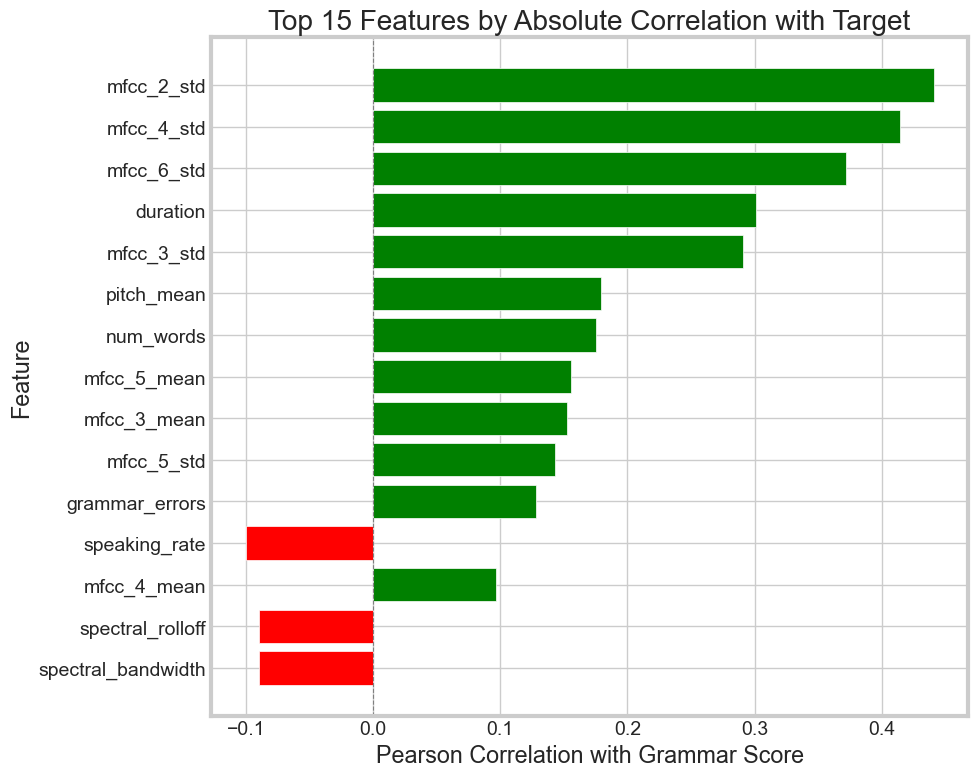

In [9]:


print("\n--- Preparing Features for Modeling ---")

# --- Training Data Preparation ---
if train_features.empty:
    print("[ERROR] Cannot prepare training features as the DataFrame is empty.")
    # Must stop if training is required
    exit()
else:
    print("Preparing training features (X_train, y_train)...")
    # Define columns that should NOT be used as features
    cols_to_drop_for_X = ['file_name', 'transcription', 'label']

    # Identify feature columns present in the dataframe
    feature_cols = [col for col in train_features.columns if col not in cols_to_drop_for_X]

    # Ensure label column exists
    if 'label' not in train_features.columns:
        print("[ERROR] 'label' column is missing from the training features DataFrame. Cannot define y_train.")
        exit()

    # Create X_train and y_train
    X_train = train_features[feature_cols].copy()
    y_train = train_features['label'].copy()

    print(f"Identified {len(feature_cols)} potential feature columns.")
    # print(f"Feature columns: {feature_cols[:10]}...") # Optional: list some features

    # --- Data Cleaning and Validation for X_train ---
    # 1. Check for non-numeric columns (should ideally not happen if extraction is correct)
    non_numeric_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"[WARNING] Non-numeric columns found in features: {non_numeric_cols}.")
       
        print(f"Dropping non-numeric columns: {non_numeric_cols}")
        X_train = X_train.drop(columns=non_numeric_cols)
        feature_cols = X_train.columns.tolist() # Update feature list
        print(f"Remaining numeric features: {len(feature_cols)}")

    # 2. Check for missing values (NaN or Infinite)
    print("\nChecking for missing values (NaN/Inf) in X_train...")
    nans = X_train.isnull().sum().sum()
    infs = np.isinf(X_train).values.sum() # More reliable way to count infs
    print(f"NaN values found: {nans}")
    print(f"Infinite values found: {infs}")

    # 3. Handle Infinite values first (replace with NaN)
    if infs > 0:
        print(f"Replacing {infs} infinite values with NaN...")
        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        nans = X_train.isnull().sum().sum() # Recalculate NaNs count
        print(f"NaN values after replacing infs: {nans}")

    # 4. Handle NaN values (Impute with median)
    if nans > 0:
        print("Imputing missing values (NaNs) with column medians...")
        # Calculate medians *before* filling N/A - Store medians for later use on test set
        try:
            medians = X_train.median()
            X_train.fillna(medians, inplace=True)
            # Verify imputation
            remaining_nans = X_train.isnull().sum().sum()
            if remaining_nans == 0:
                 print("Missing values (NaNs) filled successfully using medians.")
            else:
                 print(f"[WARNING] {remaining_nans} NaN values remain after attempting imputation. Check columns: {X_train.isnull().sum()[X_train.isnull().sum() > 0]}")
                 # Consider more robust imputation or dropping columns/rows if issues persist
        except Exception as e:
            print(f"[ERROR] Failed during NaN imputation: {e}. Missing values may persist.")
            # Store empty medians or handle error
            medians = pd.Series(dtype=float) # Empty series if calculation failed
    else:
        print("No NaN values found that require imputation.")
        # Still calculate medians for potential use on test set
        medians = X_train.median()


    # 5. Final check for data integrity
    if X_train.isnull().sum().sum() > 0 or np.isinf(X_train.values).sum() > 0:
        print("[ERROR] NaN or Infinite values still present in X_train after cleaning. Modeling might fail.")
    else:
        print("X_train data cleaned (NaNs/Infs handled).")


    # --- Feature Correlation Analysis ---
    if not y_train.isnull().any() and not X_train.empty:
        print("\nCalculating feature correlation with target label (Grammar Score)...")
        correlations = []
        valid_feature_cols_for_corr = X_train.columns # Use columns present after cleaning
        for col in valid_feature_cols_for_corr:
             # Ensure column is numeric and has some variance before calculating correlation
             if pd.api.types.is_numeric_dtype(X_train[col]) and X_train[col].nunique() > 1:
                try:
                    # Use pandas corr() for robustness, handles potential NaNs if any slipped through
                    # Or use scipy.stats.pearsonr for p-value if needed
                    corr_val = X_train[col].corr(y_train)
                    # corr_val, p_val = pearsonr(X_train[col], y_train) # Alternative
                    if not np.isnan(corr_val):
                         correlations.append((col, corr_val))
                    # else: print(f"[DEBUG] NaN correlation for {col}")
                except Exception as e:
                     print(f"[WARNING] Could not calculate correlation for feature '{col}': {e}")
             # else: print(f"[DEBUG] Skipping correlation for non-numeric or constant column: {col}")


        if correlations:
             # Sort by absolute correlation value, descending
             correlations.sort(key=lambda x: abs(x[1]), reverse=True)

             print("\nTop 10 features by absolute correlation with grammar score:")
             for feature, corr in correlations[:10]:
                print(f"  - {feature}: {corr:.4f}")

             # Plot top features by correlation
             print("\nPlotting top 15 features by absolute correlation...")
             try:
                 plt.figure(figsize=(10, 8)) # Adjusted size
                 top_corrs_plot = correlations[:15]
                 features_plot, corrs_plot = zip(*top_corrs_plot)
                 colors = ['g' if c > 0 else 'r' for c in corrs_plot] # Green for positive, Red for negative
                 # Create horizontal bar plot for better readability of feature names
                 plt.barh(range(len(features_plot)), corrs_plot, color=colors, align='center')
                 plt.yticks(range(len(features_plot)), features_plot)
                 plt.xlabel('Pearson Correlation with Grammar Score')
                 plt.ylabel('Feature')
                 plt.title('Top 15 Features by Absolute Correlation with Target')
                 plt.gca().invert_yaxis() # Display most correlated at the top
                 plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8) # Add zero line
                 plt.tight_layout()
                 plt.show()
                 plt.close()
             except Exception as plot_e:
                  print(f"[ERROR] Failed to plot feature correlations: {plot_e}")

        else:
             print("[WARNING] No valid feature correlations could be calculated.")
    elif X_train.empty:
         print("[INFO] Skipping correlation analysis as X_train is empty.")
    else: # y_train has NaNs
         print("[INFO] Skipping correlation analysis as target label (y_train) contains missing values.")

# ====================================================
# 9. Model Training and Evaluation (Cross-Validation)
# ====================================================



--- Model Training and Cross-Validation ---

Evaluating models using 5-fold cross-validation...
Using SelectKBest with k=30 (out of 35 features).

--- Evaluating: Linear Regression ---
  Avg Pearson Correlation: 0.5272 (+/- 0.0558)
  Avg RMSE: 0.9118 (+/- 0.0385)
  Evaluation time: 3.36 seconds

--- Evaluating: Ridge ---
  Avg Pearson Correlation: 0.5291 (+/- 0.0560)
  Avg RMSE: 0.9087 (+/- 0.0380)
  Evaluation time: 2.07 seconds

--- Evaluating: Lasso ---
  Avg Pearson Correlation: 0.5424 (+/- 0.0464)
  Avg RMSE: 0.8887 (+/- 0.0365)
  Evaluation time: 2.39 seconds

--- Evaluating: Random Forest ---
  Avg Pearson Correlation: 0.6308 (+/- 0.0344)
  Avg RMSE: 0.8204 (+/- 0.0361)
  Evaluation time: 2.34 seconds

--- Evaluating: Gradient Boosting ---
  Avg Pearson Correlation: 0.6384 (+/- 0.0367)
  Avg RMSE: 0.8108 (+/- 0.0310)
  Evaluation time: 0.88 seconds

--- Evaluating: XGBoost ---
[ERROR] Failed evaluating XGBoost - ValueError: Must have at least 1 validation dataset for early stop

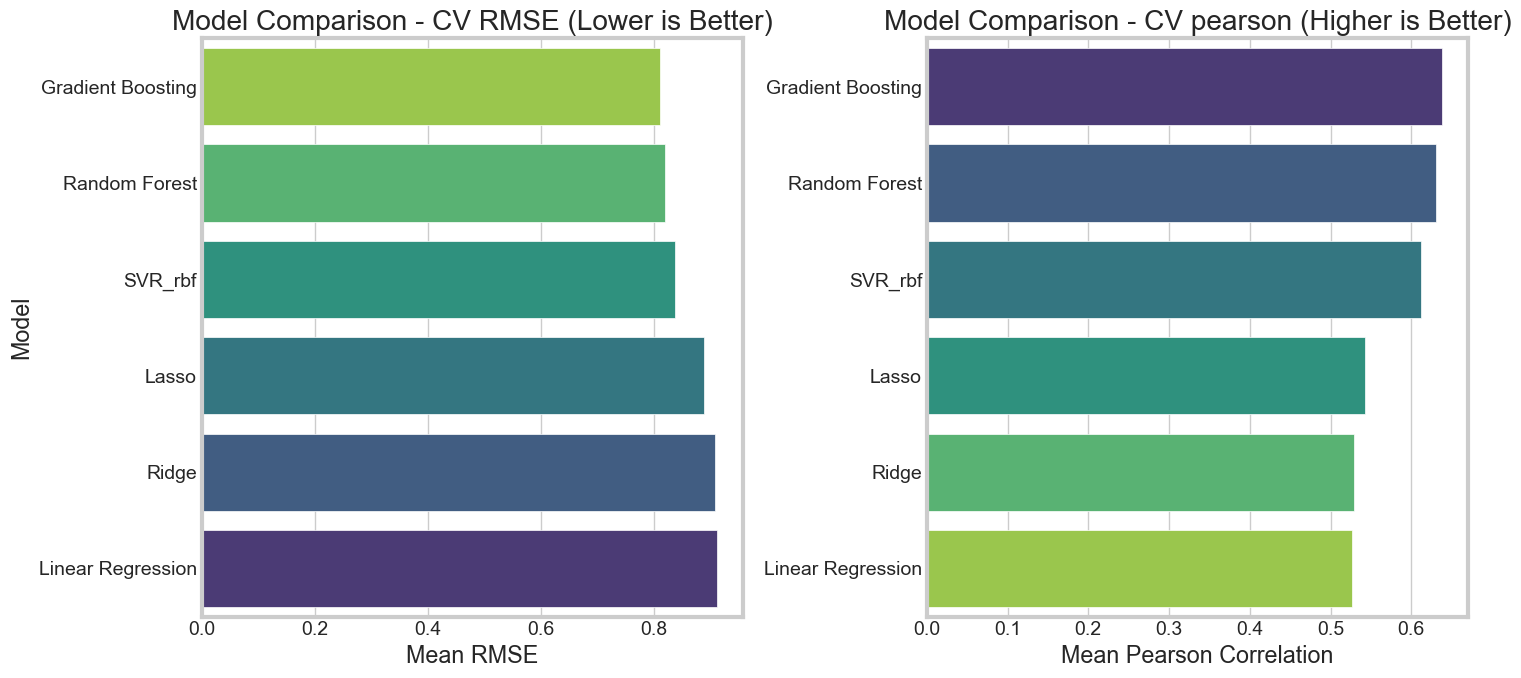

In [10]:

print("\n--- Model Training and Cross-Validation ---")

# Ensure X_train and y_train are available and valid before proceeding
if 'X_train' not in locals() or 'y_train' not in locals() or X_train.empty:
     print("[ERROR] Training data (X_train/y_train) not available or empty. Skipping model training and evaluation.")
     models = {} # Ensure models dict is empty to skip loops below
     best_model_name = None
     final_pipeline = None
else:
    # Define models to evaluate
    models = {
        # Basic models
        'Linear Regression': LinearRegression(n_jobs=-1),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'Lasso': Lasso(alpha=0.01, random_state=42, max_iter=3000), # Increased max_iter further

        # Ensemble models - Adjusted hyperparameters for potentially better performance/speed balance
        'Random Forest': RandomForestRegressor(
            n_estimators=150,       # More trees
            max_depth=15,           # Limit depth
            min_samples_split=5,    # Min samples to split
            min_samples_leaf=3,     # Min samples per leaf
            random_state=42,
            n_jobs=-1               # Use all cores
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,       # More trees
            learning_rate=0.05,     # Slightly lower learning rate
            max_depth=5,            # Reasonable depth
            subsample=0.8,          # Use a fraction of samples per tree
            random_state=42
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,   # Also sample columns per tree
            objective='reg:squarederror', # Standard objective for regression
            random_state=42,
            n_jobs=-1,
            # Use tree_method='hist' for faster training on large datasets if needed
            # tree_method='hist',
            early_stopping_rounds=10 # Optional: Stop early if validation score doesn't improve
        ),

        # Support Vector Machine
        'SVR_rbf': SVR(
            kernel='rbf',
            C=1.0,                  # Regularization parameter
            epsilon=0.1,            # Margin of tolerance
            gamma='scale'           # Default gamma strategy
            # cache_size=500        # Increase cache size if memory allows (for large datasets)
        )
        # 'SVR_linear': SVR(kernel='linear', C=0.1) # Optional: Linear SVR
    }

    # --- Cross-Validation Setup ---
    print(f"\nEvaluating models using {CV_FOLDS}-fold cross-validation...")
    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)

  
    def pearson_scorer(y_true, y_pred):
        """Scorer function for Pearson correlation, handles potential constant input."""
        if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
            return 0.0 # Return 0 if variance is zero (prevents error)
        corr, _ = pearsonr(y_true, y_pred)
        return corr if not np.isnan(corr) else 0.0

    def rmse_scorer(y_true, y_pred):
        """Scorer function for RMSE."""
        return np.sqrt(mean_squared_error(y_true, y_pred))

    scoring = {
        'pearson': make_scorer(pearson_scorer, greater_is_better=True),
        'neg_rmse': make_scorer(rmse_scorer, greater_is_better=False) # Use negative RMSE for consistency if maximizing
    }
    primary_metric = 'pearson' # Metric to select the best model

    # --- Model Evaluation Loop ---
    cv_results = {}
    pipelines = {} # Store fitted pipelines for each model if needed later

    # Determine K for SelectKBest dynamically
    num_total_features = X_train.shape[1]
    k_best = min(FEATURE_SELECTION_K, num_total_features)
    if k_best < 1:
        print("[ERROR] Number of features is less than 1. Cannot perform feature selection or train models.")
        models = {} # Skip evaluation loop
        best_model_name = None
        final_pipeline = None
    else:
        print(f"Using SelectKBest with k={k_best} (out of {num_total_features} features).")


    for name, model in models.items():
        start_time = time.time()
        print(f"\n--- Evaluating: {name} ---")

        # Create pipeline: Scale -> Select Features -> Model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(score_func=f_regression, k=k_best)), # Use f_regression for regression tasks
            ('model', model)
        ])
        pipelines[name] = pipeline # Store the pipeline structure

        try:
           
            scores = sklearn.model_selection.cross_validate(
                pipeline, X_train, y_train, cv=cv,
                scoring=scoring,
                n_jobs=-1, # Parallelize CV folds
                return_train_score=False, # Don't need training scores here
                error_score='raise'
            )

            # Calculate average and standard deviation for each metric
            avg_pearson = np.mean(scores['test_pearson'])
            std_pearson = np.std(scores['test_pearson'])
            # RMSE is stored as negative, so negate it back
            avg_rmse = -np.mean(scores['test_neg_rmse'])
            std_rmse = np.std(scores['test_neg_rmse']) # Std dev is same for neg_rmse and rmse

            cv_results[name] = {'Pearson Mean': avg_pearson, 'Pearson Std': std_pearson,
                                'RMSE Mean': avg_rmse, 'RMSE Std': std_rmse}

            print(f"  Avg Pearson Correlation: {avg_pearson:.4f} (+/- {std_pearson:.4f})")
            print(f"  Avg RMSE: {avg_rmse:.4f} (+/- {std_rmse:.4f})")
            print(f"  Evaluation time: {time.time() - start_time:.2f} seconds")

        except ValueError as ve:
             # Catch common errors like input containing NaNs (should be handled earlier, but good failsafe)
             print(f"[ERROR] Failed evaluating {name} - ValueError: {ve}")
             print("  This might indicate remaining NaNs/Infs or issues with feature selection/model.")
             cv_results[name] = {'Pearson Mean': 0.0, 'Pearson Std': 0.0, 'RMSE Mean': np.inf, 'RMSE Std': 0.0}
        except Exception as e:
            print(f"[ERROR] Failed evaluating {name} - Unexpected Error: {type(e).__name__} - {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback for debugging
            cv_results[name] = {'Pearson Mean': 0.0, 'Pearson Std': 0.0, 'RMSE Mean': np.inf, 'RMSE Std': 0.0}


    # --- Select Best Model based on CV Primary Metric ---
    best_model_name = None
    if not cv_results:
         print("\n[ERROR] No models were successfully evaluated. Cannot select best model.")
    else:
         # Filter out models that completely failed (e.g., RMSE=inf or Pearson=0)
         valid_results = {name: res for name, res in cv_results.items()
                          if res['RMSE Mean'] != np.inf and not np.isnan(res['Pearson Mean']) and res['Pearson Mean'] != 0.0}

         if not valid_results:
             print("\n[ERROR] All models failed evaluation or yielded zero correlation. Cannot select best model.")
         else:
             # Select model with the highest mean Pearson correlation
             best_model_name = max(valid_results, key=lambda name: valid_results[name]['Pearson Mean'])
             best_pearson_cv = valid_results[best_model_name]['Pearson Mean']
             best_rmse_cv = valid_results[best_model_name]['RMSE Mean']

             print(f"\n--- Best Model Selection (based on CV {primary_metric}) ---")
             print(f"Best model: {best_model_name}")
             print(f"  CV Pearson Correlation: {best_pearson_cv:.4f}")
             print(f"  CV RMSE: {best_rmse_cv:.4f}")


             # --- Plot Model Performance Comparison ---
             print("\nPlotting model performance comparison (CV results)...")
             try:
                 results_df = pd.DataFrame(valid_results).T # Transpose for plotting
                 results_df = results_df.sort_values('Pearson Mean', ascending=False) # Sort by best Pearson

                 fig, axes = plt.subplots(1, 2, figsize=(15, 7)) # Create 2 subplots

                 # Plot RMSE (Lower is better)
                 sns.barplot(x=results_df['RMSE Mean'], y=results_df.index, palette='viridis_r', orient='h', ax=axes[0])
                 axes[0].set_title('Model Comparison - CV RMSE (Lower is Better)')
                 axes[0].set_xlabel('Mean RMSE')
                 axes[0].set_ylabel('Model')

                 # Plot Pearson Correlation (Higher is better)
                 sns.barplot(x=results_df['Pearson Mean'], y=results_df.index, palette='viridis', orient='h', ax=axes[1])
                 axes[1].set_title(f'Model Comparison - CV {primary_metric} (Higher is Better)')
                 axes[1].set_xlabel(f'Mean {primary_metric.capitalize()} Correlation')
                 axes[1].set_ylabel('') # Remove redundant y-label

                 plt.tight_layout()
                 plt.show()
                 plt.close()
             except Exception as plot_e:
                 print(f"[ERROR] Failed to plot model comparison: {plot_e}")

# ====================================================
# 10. Hyperparameter Tuning for Best Model 
# ====================================================

In [11]:


final_pipeline = None # Initialize final pipeline variable

if best_model_name is None or best_model_name not in models:
    print("\n[INFO] No best model selected or available. Skipping hyperparameter tuning and final training.")
elif not ENABLE_TUNING:
    print(f"\n--- Final Model Training ({best_model_name} with Defaults) ---")
    print("Hyperparameter tuning is disabled (ENABLE_TUNING=False).")
    print(f"Training the final '{best_model_name}' model pipeline on all training data using default parameters...")

    # Get the pipeline structure used during CV
    final_pipeline = pipelines.get(best_model_name)
    if final_pipeline is None:
        print(f"[ERROR] Could not retrieve pipeline structure for {best_model_name}. Cannot train final model.")
    else:
        try:
            start_train_time = time.time()
            final_pipeline.fit(X_train, y_train)
            print(f"Final model training completed in {time.time() - start_train_time:.2f} seconds.")
        except Exception as e:
            print(f"[ERROR] Failed to train the final default model pipeline for {best_model_name}: {e}")
            final_pipeline = None # Set to None if fitting failed

elif best_model_name and best_model_name in models: # Tuning is enabled and a best model exists
    print(f"\n--- Hyperparameter Tuning for {best_model_name} ---")

    best_model_instance = models[best_model_name] # Get the base model instance

   
    possible_k_values = sorted(list(set([10, 15, 20, k_best, min(k_best + 10, num_total_features)]))) # Example dynamic k values
    possible_k_values = [k for k in possible_k_values if k <= num_total_features and k > 0] # Ensure valid k
    print(f"Tuning selector__k with values: {possible_k_values}")

    param_grids = {
        'Ridge': {
            'selector__k': possible_k_values,
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]
        },
        'Lasso': {
            'selector__k': possible_k_values,
            'model__alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
        },
        'Random Forest': {
            'selector__k': possible_k_values,
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 15, 20, None],
            'model__min_samples_split': [3, 5, 10],
            'model__min_samples_leaf': [2, 3, 5]
        },
        'Gradient Boosting': {
            'selector__k': possible_k_values,
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.7, 0.8, 0.9, 1.0]
        },
        'XGBoost': {
            'selector__k': possible_k_values,
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__colsample_bytree': [0.7, 0.8, 0.9],
            'model__subsample': [0.7, 0.8, 0.9]
            # 'model__gamma': [0, 0.1, 0.2], # Optional: Regularization
            # 'model__reg_alpha': [0, 0.01, 0.1] # Optional: L1 Reg
        },
        'SVR_rbf': {
            'selector__k': possible_k_values,
            'model__C': [0.1, 1, 10, 50, 100],          # Wider range for C
            'model__gamma': ['scale', 'auto', 0.01, 0.1], # Gamma options
            'model__epsilon': [0.05, 0.1, 0.2]       # Epsilon range
        }
        # Add grids for other models if needed
    }

    if best_model_name in param_grids:
        param_grid = param_grids[best_model_name]

        # Get the base pipeline structure for tuning
        pipeline_tune = pipelines.get(best_model_name)
        if pipeline_tune is None:
             print(f"[ERROR] Could not retrieve pipeline structure for {best_model_name}. Skipping tuning.")
        else:
           
             grid_search = GridSearchCV(
                 estimator=pipeline_tune,
                 param_grid=param_grid,
                 scoring=scoring,            # Pass the dictionary of scorers
                 refit=primary_metric,       # Refit based on the primary metric (Pearson)
                 cv=cv,
                 n_jobs=-1,                  # Use all available cores
                 verbose=2                   # Show more progress
             )

             print(f"Starting GridSearchCV for {best_model_name} (this may take time)...")
             try:
                 start_tune_time = time.time()
                 grid_search.fit(X_train, y_train)
                 print(f"GridSearchCV completed in {time.time() - start_tune_time:.2f} seconds.")

                 print(f"\n--- Tuning Results for {best_model_name} ---")
                 print(f"Best parameters found: {grid_search.best_params_}")
                 print(f"Best CV {primary_metric.capitalize()} score: {grid_search.best_score_:.4f}")

                 # Access other scores for the best parameters if needed
                 best_index = grid_search.best_index_
                 # Remember RMSE score is negative in 'neg_rmse'
                 best_rmse_tuned = -grid_search.cv_results_[f'mean_test_{list(scoring.keys())[1]}'][best_index]
                 print(f"RMSE score for best parameters: {best_rmse_tuned:.4f}")


                 # The best pipeline is now stored in grid_search.best_estimator_
                 final_pipeline = grid_search.best_estimator_
                 print("\nUsing tuned model pipeline for final predictions.")
                 # Note: The final pipeline is already fitted on the full training data because refit=True

             except Exception as e:
                 print(f"[ERROR] GridSearchCV failed for {best_model_name}: {e}")
                 print("Falling back to the best model with default parameters found during initial CV.")
                 # Fallback: Use the original pipeline with default params, need to refit
                 final_pipeline = pipelines.get(best_model_name)
                 if final_pipeline:
                     try:
                         print(f"Re-fitting the default {best_model_name} pipeline...")
                         final_pipeline.fit(X_train, y_train)
                         print("Fallback default model fitted.")
                     except Exception as fit_e:
                          print(f"[ERROR] Failed to fit the fallback default model pipeline: {fit_e}")
                          final_pipeline = None # Fitting failed


    else: # No grid defined for the best model
        print(f"No hyperparameter grid defined for {best_model_name}. Using default parameters.")
        # Use the original pipeline, need to refit
        final_pipeline = pipelines.get(best_model_name)
        if final_pipeline:
            try:
                print(f"Fitting the default {best_model_name} pipeline...")
                final_pipeline.fit(X_train, y_train)
                print("Default model fitted.")
            except Exception as fit_e:
                 print(f"[ERROR] Failed to fit the default model pipeline: {fit_e}")
                 final_pipeline = None # Fitting failed


--- Final Model Training (Gradient Boosting with Defaults) ---
Hyperparameter tuning is disabled (ENABLE_TUNING=False).
Training the final 'Gradient Boosting' model pipeline on all training data using default parameters...
Final model training completed in 0.77 seconds.


# ====================================================
# 11. Final Model Evaluation on Training Data
# ====================================================


--- Evaluating Final Model Performance on Training Data ---
Using model: Gradient Boosting
Parameters: Defaults used in CV

Training Set Performance Metrics (Final Model):
  RMSE: 0.1282
  MAE:  0.1043
  R²:   0.9850
  Pearson Correlation: 0.9949

Plotting predictions vs actual values on training data...


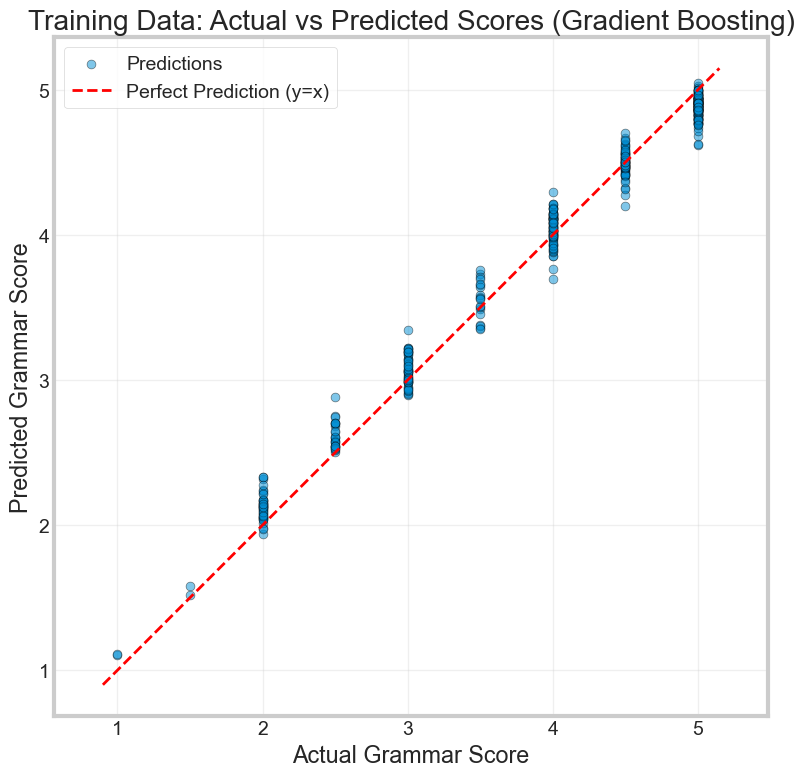

Plotting prediction error distribution on training data...


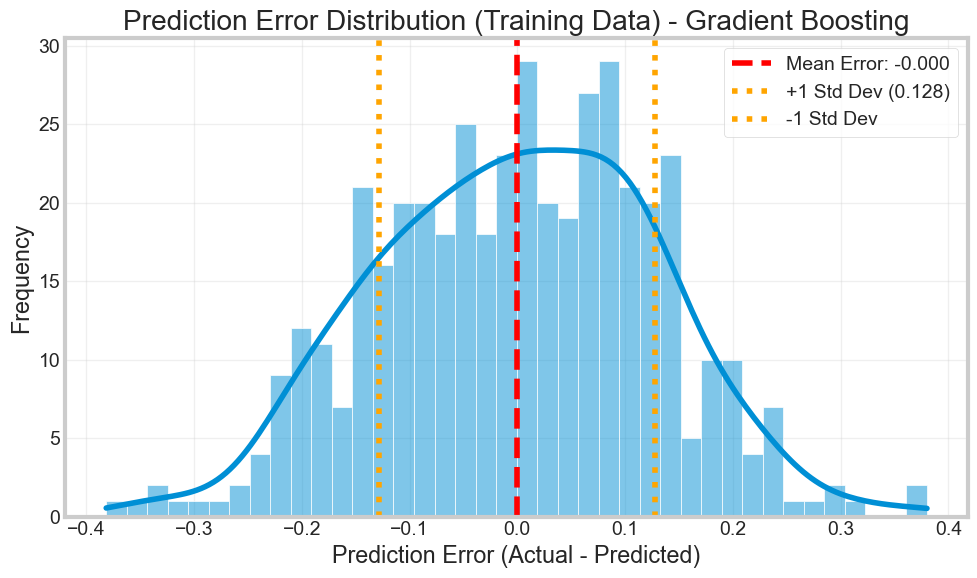

In [12]:

if final_pipeline and 'X_train' in locals() and 'y_train' in locals():
    print("\n--- Evaluating Final Model Performance on Training Data ---")
    print(f"Using model: {best_model_name or 'Unknown'}")
    # If tuning was done, best_params_ might exist
    if ENABLE_TUNING and 'grid_search' in locals() and hasattr(grid_search, 'best_params_'):
         print(f"Parameters: {grid_search.best_params_}")
    else:
         print("Parameters: Defaults used in CV")


    # Make predictions on the training data itself (to check for overfitting etc.)
    try:
        y_train_pred = final_pipeline.predict(X_train)

        # Calculate metrics
        train_rmse = rmse_scorer(y_train, y_train_pred) # Use our scorer function
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_pearson = pearson_scorer(y_train, y_train_pred) # Use our scorer function

        print("\nTraining Set Performance Metrics (Final Model):")
        print(f"  RMSE: {train_rmse:.4f}")
        print(f"  MAE:  {train_mae:.4f}")
        print(f"  R²:   {train_r2:.4f}")
        print(f"  Pearson Correlation: {train_pearson:.4f}")

        # --- Plot Predictions vs Actual (Training Data) ---
        print("\nPlotting predictions vs actual values on training data...")
        try:
            plt.figure(figsize=(8, 8))
            plt.scatter(y_train, y_train_pred, alpha=0.5, edgecolors='k', s=40, label='Predictions')
            # Add a diagonal line y=x for reference
            min_val = min(y_train.min(), y_train_pred.min()) - 0.1
            max_val = max(y_train.max(), y_train_pred.max()) + 0.1
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')
            plt.xlabel('Actual Grammar Score')
            plt.ylabel('Predicted Grammar Score')
            plt.title(f'Training Data: Actual vs Predicted Scores ({best_model_name})')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.xlim(min_val, max_val)
            plt.ylim(min_val, max_val)
            plt.axis('equal') # Ensure aspect ratio is equal for visual clarity
            plt.tight_layout()
            plt.show()
            plt.close()
        except Exception as plot_e:
             print(f"[ERROR] Failed to plot Actual vs Predicted: {plot_e}")

        # --- Plot Error Distribution (Training Data) ---
        print("Plotting prediction error distribution on training data...")
        try:
            errors = y_train - y_train_pred
            plt.figure(figsize=(10, 6))
            sns.histplot(errors, kde=True, bins=40) # More bins might show more detail
            plt.xlabel('Prediction Error (Actual - Predicted)')
            plt.ylabel('Frequency')
            plt.title(f'Prediction Error Distribution (Training Data) - {best_model_name}')
            mean_err = errors.mean()
            std_err = errors.std()
            plt.axvline(mean_err, color='r', linestyle='--', label=f'Mean Error: {mean_err:.3f}')
            plt.axvline(mean_err + std_err, color='orange', linestyle=':', label=f'+1 Std Dev ({std_err:.3f})')
            plt.axvline(mean_err - std_err, color='orange', linestyle=':', label=f'-1 Std Dev')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            plt.close()
        except Exception as plot_e:
             print(f"[ERROR] Failed to plot error distribution: {plot_e}")


    except Exception as e:
        print(f"[ERROR] Failed during final model evaluation on training data: {e}")
        import traceback
        traceback.print_exc()

elif not final_pipeline:
     print("\n[INFO] Skipping final model evaluation as no final pipeline was successfully trained.")
else: # X_train or y_train missing
     print("\n[INFO] Skipping final model evaluation due to missing training data.")


# ====================================================
# 12. Feature Importance Analysis
# ====================================================


--- Feature Importance Analysis ---
Analyzing feature importance for model: Gradient Boosting
Number of features selected by SelectKBest: 30

Top 20 Most Important Features (Selected by KBest, based on Importance (Tree-based)):
           Feature  Importance
        mfcc_4_std    0.165990
        mfcc_2_std    0.120698
         num_words    0.064581
 lexical_diversity    0.063500
   avg_word_length    0.060511
        mfcc_6_std    0.034306
        mfcc_5_std    0.032545
     pos_diversity    0.032458
     num_sentences    0.031570
               rms    0.027727
       mfcc_3_mean    0.027467
       mfcc_5_mean    0.026446
        mfcc_1_std    0.025920
     speaking_rate    0.024308
       mfcc_6_mean    0.024098
        pitch_mean    0.023623
       mfcc_2_mean    0.022922
spectral_bandwidth    0.022763
       mfcc_4_mean    0.020986
   unique_pos_tags    0.019848


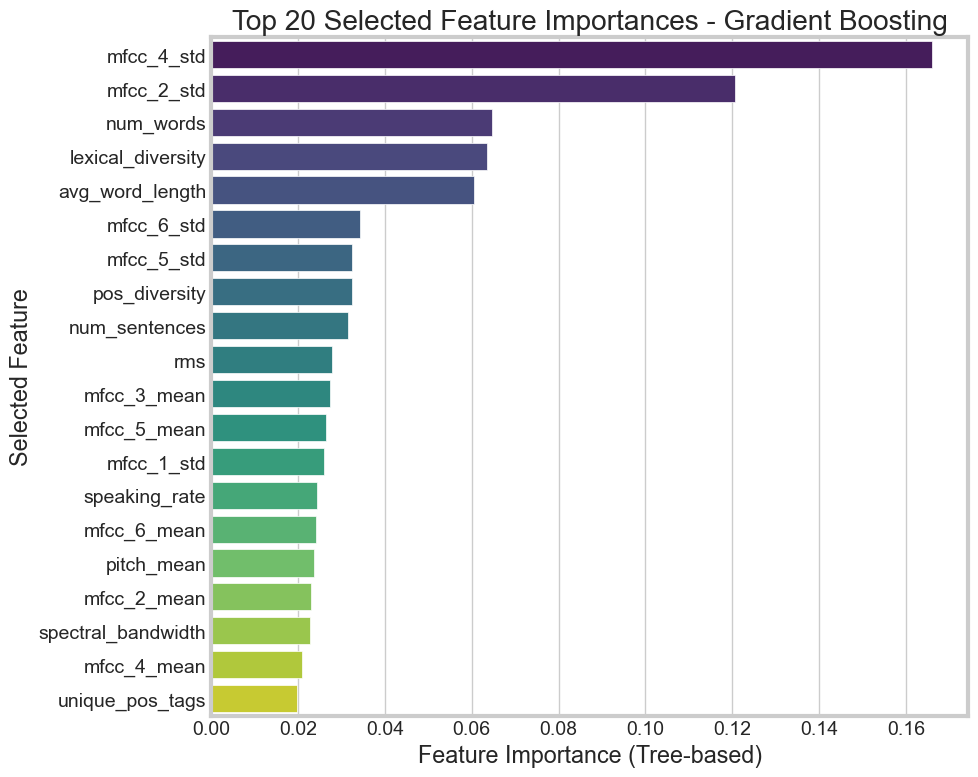

In [13]:


if final_pipeline and 'X_train' in locals() and not X_train.empty:
    print("\n--- Feature Importance Analysis ---")
    print(f"Analyzing feature importance for model: {best_model_name}")
    try:
        # Access steps from the final fitted pipeline
        scaler_step = final_pipeline.named_steps.get('scaler')
        selector_step = final_pipeline.named_steps.get('selector')
        model_step = final_pipeline.named_steps.get('model')

        if not model_step:
             print("[ERROR] Model step not found in the final pipeline. Cannot determine importance.")
        elif not selector_step:
             print("[WARNING] Selector step ('SelectKBest') not found in the pipeline.")
             # Fallback: Check if the model itself has importance and try to use all original features
             if hasattr(model_step, 'feature_importances_') or hasattr(model_step, 'coef_'):
                 print("Attempting importance calculation using all features (before potential selection).")
                 # Use original feature names from X_train *before* selection
                 feature_names_imp = X_train.columns.tolist() # Assumes X_train holds the state before selection
                 importance_values = None
                 importance_type = None

                 if hasattr(model_step, 'feature_importances_'):
                     importance_values = model_step.feature_importances_
                     importance_type = "Importance (Tree-based)"
                 elif hasattr(model_step, 'coef_'):
                     # Use absolute value for linear models coefficient magnitude
                     importance_values = np.abs(model_step.coef_.flatten())
                     importance_type = "Abs Coefficient (Linear)"

                 if importance_values is not None and len(importance_values) == len(feature_names_imp):
                      # Create DataFrame and plot
                      importance_df = pd.DataFrame({'Feature': feature_names_imp, 'Importance': importance_values})
                      importance_df = importance_df.sort_values('Importance', ascending=False)
                      num_features_to_plot = min(20, len(importance_df))

                      print(f"\nTop {num_features_to_plot} Features (Based on All Features - {importance_type}):")
                      print(importance_df.head(num_features_to_plot).to_string(index=False))

                      plt.figure(figsize=(10, 8))
                      sns.barplot(x='Importance', y='Feature', data=importance_df.head(num_features_to_plot),
                                  palette='viridis', orient='h')
                      plt.xlabel(f'{importance_type}')
                      plt.ylabel('Feature')
                      plt.title(f'Top {num_features_to_plot} Feature Importances (All Features) - {best_model_name}')
                      plt.tight_layout()
                      plt.show()
                      plt.close()
                 else:
                     print(f"[WARNING] Could not retrieve or align importance values for all features. Length mismatch: {len(importance_values) if importance_values is not None else 'N/A'} vs {len(feature_names_imp)}.")
             else:
                  print(f"[INFO] Model type '{type(model_step).__name__}' does not provide standard importance attributes, and no selector was found.")

        else: 
             selected_feature_indices = selector_step.get_support(indices=True)
             # Get the names of these features from the original X_train columns
             selected_feature_names = X_train.columns[selected_feature_indices].tolist()
             print(f"Number of features selected by SelectKBest: {len(selected_feature_names)}")


             importance_values = None
             importance_type = None

             # Check model type for importance attribute
             if hasattr(model_step, 'feature_importances_'): # Tree-based models (RF, GB, XGB)
                 importance_values = model_step.feature_importances_
                 importance_type = "Importance (Tree-based)"
                 # Use raw importance values directly
             elif hasattr(model_step, 'coef_'): # Linear models (Linear, Ridge, Lasso), SVR(kernel='linear')
                 # Use absolute coefficients for ranking magnitude, but plot original for directionality
                 importance_values = model_step.coef_.flatten()
                 importance_type = "Coefficient (Linear Model)"
             # Note: SVR with RBF kernel doesn't have direct feature_importances_ or coef_.

             if importance_values is not None:
                 if len(importance_values) == len(selected_feature_names):
                     # Create a DataFrame for easier handling and plotting
                     importance_df = pd.DataFrame({
                         'Feature': selected_feature_names,
                         'Importance': importance_values
                     })
                     # Sort by absolute value for ranking, but keep original sign
                     importance_df['AbsImportance'] = importance_df['Importance'].abs()
                     importance_df = importance_df.sort_values('AbsImportance', ascending=False)

                     # Plot top N features
                     num_features_to_plot = min(20, len(importance_df)) # Plot top 20 selected features
                     print(f"\nTop {num_features_to_plot} Most Important Features (Selected by KBest, based on {importance_type}):")
                     # Show Feature and original Importance/Coefficient value
                     print(importance_df[['Feature', 'Importance']].head(num_features_to_plot).to_string(index=False))


                     plt.figure(figsize=(10, 8))
                     # Use a palette that shows positive/negative coefficients well, like coolwarm
                     plot_palette = 'viridis' if importance_type.startswith("Importance") else 'coolwarm'
                     sns.barplot(x='Importance', y='Feature', data=importance_df.head(num_features_to_plot),
                                 palette=plot_palette, orient='h')
                     plt.xlabel(f'Feature {importance_type}')
                     plt.ylabel('Selected Feature')
                     plt.title(f'Top {num_features_to_plot} Selected Feature Importances - {best_model_name}')
                     plt.tight_layout()
                     plt.show()
                     plt.close()
                 else:
                      print(f"[ERROR] Mismatch! Number of importance values ({len(importance_values)}) != number of selected features ({len(selected_feature_names)}).")
                      print("  Importance values:", importance_values[:5])
                      print("  Selected features:", selected_feature_names[:5])

             else:
                  print(f"[INFO] Model type '{type(model_step).__name__}' used in the pipeline does not provide standard feature importance ('feature_importances_' or 'coef_').")
                  print("  Consider using permutation importance (sklearn.inspection.permutation_importance) for model-agnostic importance, especially for models like SVR with RBF kernel.")

    except AttributeError as ae:
         print(f"[ERROR] Failed accessing pipeline steps/attributes during importance analysis: {ae}")
         print("  Ensure the final_pipeline was fitted correctly.")
    except Exception as e:
        print(f"[ERROR] An unexpected error occurred during feature importance analysis: {e}")
        import traceback
        traceback.print_exc()

elif not final_pipeline:
     print("\n[INFO] Skipping feature importance analysis as no final pipeline is available.")
else: # X_train is empty
     print("\n[INFO] Skipping feature importance analysis as X_train is empty.")


# ====================================================
# 13. Prepare Test Predictions and Submission File
# ====================================================

In [14]:


print("\n--- Preparing Test Predictions and Submission File ---")
submission_filename = 'submission.csv' # Define submission filename

# Check if we have everything needed for prediction
if final_pipeline is None:
     print("[ERROR] No final model pipeline available. Cannot generate test predictions.")
elif test_features.empty:
     print("[ERROR] Test features DataFrame is empty. Cannot generate test predictions.")
elif 'X_train' not in locals() or 'feature_cols' not in locals() or 'medians' not in locals():
     print("[ERROR] Training features, feature column list ('feature_cols'), or training medians ('medians') not available. Cannot align test data for prediction.")
else:
    print(f"Generating predictions for {len(test_features)} test samples using the final '{best_model_name}' pipeline...")

    # 1. Prepare X_test: Select same features, handle missing columns, NaNs/Infs
    print("Preparing test features (X_test)...")
    X_test = pd.DataFrame() # Initialize empty dataframe
    missing_in_test_count = 0
    for col in feature_cols: # Use the exact feature list from training
        if col in test_features.columns:
            X_test[col] = test_features[col]
        else:
            missing_in_test_count += 1
            # Fill missing columns using training medians (critical for consistency)
            if col in medians:
                 # print(f"[DEBUG] Feature '{col}' missing in test data. Filling with training median: {medians[col]:.4f}.")
                 X_test[col] = medians[col] # Assign scalar median value to the new column
            else:
                 print(f"[WARNING] Feature '{col}' missing in test data AND training median unavailable! Filling with 0.")
                 X_test[col] = 0.0 # Fallback: Fill with 0, might affect results

    if missing_in_test_count > 0:
        print(f"[INFO] {missing_in_test_count} feature columns present in training were missing in test data and filled using training medians (or 0).")

    # Ensure column order is identical to training data
    try:
        X_test = X_test[feature_cols]
    except KeyError as ke:
        print(f"[ERROR] Failed to reorder test columns. Missing columns might still exist: {ke}")
        # Handle error: Stop or proceed with caution

    # 2. Handle NaNs/Infs in X_test using TRAINING medians
    print("Checking and handling NaNs/Infs in X_test...")
    nans_test = X_test.isnull().sum().sum()
    infs_test = np.isinf(X_test.values).sum()
    print(f"NaN values found in test set before imputation: {nans_test}")
    print(f"Infinite values found in test set before imputation: {infs_test}")

    if infs_test > 0:
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        nans_test = X_test.isnull().sum().sum() # Recalculate NaNs
        print(f"Replaced {infs_test} infinite values with NaN. Current NaNs: {nans_test}")

    if nans_test > 0:
        print("Imputing NaNs in test set using training medians...")
        X_test.fillna(medians, inplace=True) # Use medians calculated from X_train
        remaining_nans_test = X_test.isnull().sum().sum()
        if remaining_nans_test == 0:
            print("Missing values (NaNs) in test set filled successfully.")
        else:
            print(f"[WARNING] {remaining_nans_test} NaNs remain in the test set after imputation!")
            # Identify columns still containing NaNs
            print(f"Columns with remaining NaNs: {X_test.isnull().sum()[X_test.isnull().sum() > 0].index.tolist()}")


    # 3. Final check before prediction
    if X_test.isnull().sum().sum() > 0 or np.isinf(X_test.values).sum() > 0:
         print("[ERROR] NaN or Infinite values still present in X_test after cleaning. Prediction might fail or be unreliable.")
    elif X_test.shape[1] != len(feature_cols):
         print(f"[ERROR] Test data feature count ({X_test.shape[1]}) does not match training feature count ({len(feature_cols)}). Alignment failed.")
    else:
        print("X_test prepared successfully.")

        # 4. Make Predictions
        print("Making predictions on the test set...")
        try:
            test_preds = final_pipeline.predict(X_test)

            # 5. Clip predictions (optional but often recommended)
            # Use min/max from the *training* labels to constrain predictions
            min_label = train_df['label'].min()
            max_label = train_df['label'].max()
            print(f"Clipping predictions to the training label range [{min_label}, {max_label}]...")
            test_preds_clipped = np.clip(test_preds, min_label, max_label)

            # Check if clipping had any effect
            clip_diff = np.sum(test_preds != test_preds_clipped)
            if clip_diff > 0:
                print(f"[INFO] Clipping affected {clip_diff} predictions.")

            # 6. Create Submission DataFrame
            if 'file_name' not in test_features.columns:
                 print("[ERROR] 'file_name' column missing in the original test_features DataFrame. Cannot create submission.")
            else:
                 submission_df = pd.DataFrame({
                     'file_name': test_features['file_name'], # Get filenames from the original test_features df
                     'label': test_preds_clipped
                 })

                 # 7. Validate Submission File Format
                 print(f"\nValidating submission format...")
                 print(f"Submission shape: {submission_df.shape}")
                 # Check against sample submission
                 if 'sample_submission' in locals():
                     if len(submission_df) != len(sample_submission):
                         print(f"[WARNING] Submission row count ({len(submission_df)}) does not match sample_submission ({len(sample_submission)}).")
                     if set(submission_df.columns) != set(sample_submission.columns):
                          print(f"[WARNING] Submission columns {set(submission_df.columns)} do not match sample_submission columns {set(sample_submission.columns)}.")
                     if 'file_name' in submission_df.columns and set(submission_df['file_name']) != set(sample_submission['file_name']):
                         print("[WARNING] File names in submission do not perfectly match file names in sample_submission!")
                        
                 # Check for NaNs in predictions
                 if submission_df['label'].isnull().any():
                      nan_pred_count = submission_df['label'].isnull().sum()
                      print(f"[WARNING] Submission contains {nan_pred_count} NaN predictions!")
                      
                      # submission_df['label'].fillna(pred_median, inplace=True)

                 # 8. Save Submission File
                 try:
                     submission_df.to_csv(submission_filename, index=False)
                     print(f"\nSubmission file created successfully: '{submission_filename}'")
                     print("Sample of submission file (first 5 rows):")
                     print(submission_df.head().to_string())
                 except Exception as save_e:
                      print(f"[ERROR] Failed to save submission file '{submission_filename}': {save_e}")

        except Exception as pred_e:
             print(f"[ERROR] Failed to generate predictions on the test set: {pred_e}")
             import traceback
             traceback.print_exc()



--- Preparing Test Predictions and Submission File ---
Generating predictions for 204 test samples using the final 'Gradient Boosting' pipeline...
Preparing test features (X_test)...
Checking and handling NaNs/Infs in X_test...
NaN values found in test set before imputation: 0
Infinite values found in test set before imputation: 0
X_test prepared successfully.
Making predictions on the test set...
Clipping predictions to the training label range [1.0, 5.0]...
[INFO] Clipping affected 2 predictions.

Validating submission format...
Submission shape: (204, 2)

Submission file created successfully: 'submission.csv'
Sample of submission file (first 5 rows):
        file_name     label
0   audio_804.wav  2.053488
1  audio_1028.wav  3.873876
2   audio_865.wav  2.786137
3   audio_774.wav  2.497793
4  audio_1138.wav  3.179936


# ====================================================
# 14. Final Summary and Conclusion
# ====================================================

In [15]:

print("\n" + "="*60)
print("          GRAMMAR SCORING ENGINE - FINAL SUMMARY")
print("="*60)

print(f"Run Timestamp: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device Used: {device}")
print(f"ASR Model: {'openai/whisper-tiny' if asr else 'Not Loaded/Used'}")
print(f"Text Grammar Check: {'LanguageTool' if language_tool else 'Not Used/Failed'}")

print("\n--- Data Processed ---")
if 'train_features' in locals() and not train_features.empty:
    print(f"Training samples processed: {len(train_features)}")
else:
    print("Training samples: Error or Not processed")
if 'test_features' in locals() and not test_features.empty:
    print(f"Test samples processed: {len(test_features)}")
else:
    print("Test samples: Error or Not processed")

print("\n--- Model Selection and Training ---")
if best_model_name:
    print(f"Best Model Selected (based on CV {primary_metric}): {best_model_name}")
    if best_model_name in cv_results:
        print(f"  - CV {primary_metric.capitalize()}: {cv_results[best_model_name]['Pearson Mean']:.4f}")
        print(f"  - CV RMSE: {cv_results[best_model_name]['RMSE Mean']:.4f}")
    else:
        print("  - CV results not available for this model.")

    if ENABLE_TUNING and 'grid_search' in locals() and hasattr(grid_search, 'best_params_'):
        print(f"  - Hyperparameters Tuned: Yes")
        print(f"  - Best Tuned CV {primary_metric.capitalize()}: {grid_search.best_score_:.4f}")
        print(f"  - Best Parameters Found: {grid_search.best_params_}")
    elif ENABLE_TUNING:
         print("  - Hyperparameters Tuned: Enabled, but tuning may have failed or was skipped.")
    else:
        print(f"  - Hyperparameters Tuned: No (Used Defaults)")

    if final_pipeline and 'train_pearson' in locals(): # Check if final evaluation metrics exist
         print("\nPerformance on Full Training Set (Final Model):")
         print(f"  - Training RMSE: {train_rmse:.4f}")
         print(f"  - Training MAE: {train_mae:.4f}")
         print(f"  - Training Pearson: {train_pearson:.4f}")
         print(f"  - Training R²: {train_r2:.4f}")
         # Compare Train Pearson vs CV Pearson for overfitting check
         cv_p = cv_results.get(best_model_name, {}).get('Pearson Mean', np.nan)
         if not np.isnan(cv_p):
             print(f"  - Overfitting Check: Train Pearson ({train_pearson:.4f}) vs CV Pearson ({cv_p:.4f}) -> Diff: {train_pearson-cv_p:.4f}")
    else:
         print("\nPerformance metrics on the full training set are not available (model training likely failed).")

else:
    print("No best model was successfully selected or trained during this run.")

# Display feature importance summary if available
print("\n--- Feature Importance (Final Model) ---")
if 'importance_df' in locals() and not importance_df.empty:
     num_imp = min(5, len(importance_df))
     print(f"Top {num_imp} Most Important Features (from {importance_type}):")
     print(importance_df[['Feature', 'Importance']].head(num_imp).to_string(index=False))
elif 'importance_values' in locals() and importance_values is not None and 'feature_names_imp' in locals():
     num_imp = min(5, len(feature_names_imp))
     indices = np.argsort(np.abs(importance_values))[::-1]
     print(f"\nTop {num_imp} Most Important Features (All Features, from {importance_type}):")
     for i in range(num_imp):
         print(f"  - {feature_names_imp[indices[i]]}: {importance_values[indices[i]]:.4f}")
else:
     print("Feature importance information not available (model type might not support it, or analysis failed).")

print("\n--- Outcome ---")
if 'submission_df' in locals() and os.path.exists(submission_filename):
    print(f"✅ Submission file '{submission_filename}' has been generated successfully.")
    print(f"   Based on the '{best_model_name or 'selected'}' model.")
else:
    print(f"❌ Submission file '{submission_filename}' was NOT generated or failed to save.")
    print("   Check logs for errors in model training or prediction steps.")

print("\n--- Conclusion ---")
print("Script execution completed.")
print("Review the full console output and generated plots for detailed results and potential warnings/errors.")
print("Consider enabling hyperparameter tuning (set ENABLE_TUNING = True) for potentially better performance.")
print("="*60)


          GRAMMAR SCORING ENGINE - FINAL SUMMARY
Run Timestamp: 2025-04-19 17:22:42
Device Used: cpu
ASR Model: openai/whisper-tiny
Text Grammar Check: LanguageTool

--- Data Processed ---
Training samples processed: 444
Test samples processed: 204

--- Model Selection and Training ---
Best Model Selected (based on CV pearson): Gradient Boosting
  - CV Pearson: 0.6384
  - CV RMSE: 0.8108
  - Hyperparameters Tuned: No (Used Defaults)

Performance on Full Training Set (Final Model):
  - Training RMSE: 0.1282
  - Training MAE: 0.1043
  - Training Pearson: 0.9949
  - Training R²: 0.9850
  - Overfitting Check: Train Pearson (0.9949) vs CV Pearson (0.6384) -> Diff: 0.3565

--- Feature Importance (Final Model) ---
Top 5 Most Important Features (from Importance (Tree-based)):
          Feature  Importance
       mfcc_4_std    0.165990
       mfcc_2_std    0.120698
        num_words    0.064581
lexical_diversity    0.063500
  avg_word_length    0.060511

--- Outcome ---
✅ Submission file 'subm

# Grammar Scoring Engine - Approach and Results Summary

## 1. Introduction & Objective

This notebook aims to predict the grammar score of spoken English audio recordings. The approach involves extracting features from both the audio signal itself and the transcribed text obtained via Automatic Speech Recognition (ASR), and then training regression models to predict the score based on these combined features.

## 2. Data

The input data consists of:
*   Audio files (`.wav`) located in `Dataset/audios/train` and `Dataset/audios/test`.
*   A `train.csv` file mapping training audio filenames to their corresponding grammar scores (`label`).
*   A `test.csv` file listing the test audio filenames for which predictions are required.
*   A `sample_submission.csv` file showing the expected output format.

Initial exploration showed grammar scores in the training data range from 1.0 to 5.0, with a mean around 3.97.

## 3. Preprocessing and Feature Engineering

A multi-modal feature extraction process was implemented:

*   **Audio Feature Extraction:**
    *   Audio files were loaded using `librosa` and resampled to a sample rate of `SR_AUDIO_FEATURES` (8000 Hz) for general audio feature extraction.
    *   Features extracted include:
        *   **Basic:** Duration, Zero Crossing Rate (mean), Root Mean Square energy (mean).
        *   **Spectral:** Spectral Centroid (mean), Spectral Bandwidth (mean), Spectral Rolloff (mean).
        *   **Cepstral:** Mel-Frequency Cepstral Coefficients (MFCCs) - Mean and Standard Deviation of the first 6 coefficients.
        *   **Temporal/Rhythmic:** Onset Strength (mean), Tempo (estimated using beat tracking), Speaking Rate (approximated using RMS peaks per second).
        *   **Pitch:** Mean pitch (estimated using `piptrack`).
    *   Handling near-silent audio was included by returning default zero values for features to avoid errors.

*   **Speech-to-Text (ASR):**
    *   The `openai/whisper-tiny` model (via the `transformers` library pipeline) was used for ASR due to its efficiency, though larger models could potentially improve accuracy. `ffmpeg` availability was checked as it's required by the pipeline.
    *   Audio was preprocessed specifically for Whisper: loaded and resampled to `SR_ASR` (16000 Hz), and leading/trailing silence was trimmed (`top_db=25`).
    *   For longer audio files, the ASR pipeline handled chunking automatically (`chunk_length_s=30.0`, `stride_length_s=5.0`) to manage memory and context length limitations.
    *   The output transcript was cleaned by normalizing whitespace. Files with very low energy or failing preprocessing/transcription resulted in empty transcripts.

*   **Text Feature Extraction:**
    *   Features were extracted from the ASR transcripts using `nltk`, `textstat`, and `language_tool_python`.
    *   Features include:
        *   **Basic Counts:** Number of sentences, number of words (alphabetic, length > 1), average words per sentence, average word length.
        *   **Lexical:** Lexical diversity (unique words / total words).
        *   **Grammar:** Number of grammar errors detected by `LanguageTool`, grammar errors per sentence.
        *   **Readability:** Flesch Reading Ease, Flesch-Kincaid Grade level, ratio of difficult words (using `textstat`).
        *   **Syntactic:** Number of unique Part-of-Speech (POS) tags, POS diversity (unique POS tags / total words), grammatical structure diversity (simplified using POS tag trigram diversity).
    *   Default zero values were returned for features if the transcript was empty or processing failed (e.g., NLTK/textstat errors on very short text, LanguageTool initialization failure).

*   **Combined Pipeline & Caching:**
    *   The `extract_all_features` function orchestrated the loading, audio feature extraction, optional transcription, and text feature extraction for each audio file.
    *   The `process_dataset` function applied this to all train and test files, implementing a caching mechanism using `.csv` files (`train_features_v2_cache.csv`, `test_features_v2_cache.csv`) in the `cache` directory to avoid reprocessing. Progress was saved incrementally.

*   **Data Cleaning:**
    *   After feature extraction, the resulting training feature matrix (`X_train`) was checked for non-numeric columns (none expected/found), infinite values (replaced with NaN), and NaN values (imputed using the column median calculated from the *training* data). These training medians were saved for consistent imputation on the test set.

## 4. Modeling Pipeline

A standard scikit-learn `Pipeline` architecture was used for model training and evaluation:

1.  **`StandardScaler`:** Standardizes features by removing the mean and scaling to unit variance. This is crucial for models sensitive to feature scales (e.g., Ridge, Lasso, SVR).
2.  **`SelectKBest(f_regression, k=30)`:** Selects the top `k` features most correlated with the target variable using the F-test for regression. `k` was set to 30 (or the total number of features if less). This helps reduce dimensionality and potentially improves model performance/speed.
3.  **Regression Model:** The final step included one of the regression models being evaluated.

## 5. Model Evaluation and Selection

*   Several regression models were evaluated: Linear Regression, Ridge, Lasso, Random Forest Regressor, Gradient Boosting Regressor, XGBoost Regressor, and Support Vector Regressor (SVR) with an RBF kernel. *Note: XGBoost encountered an error during CV, possibly due to its early stopping configuration requiring a separate validation set within the CV fold.*
*   **Cross-Validation:** 5-Fold Cross-Validation (`KFold` with `shuffle=True`) was used to get robust performance estimates.
*   **Metrics:** Models were evaluated based on:
    *   **Pearson Correlation Coefficient:** Measures the linear correlation between predicted and actual scores (primary metric for selection, higher is better).
    *   **Root Mean Squared Error (RMSE):** Measures the average magnitude of errors (lower is better). Custom scorer functions were used within `cross_validate`.
*   **Best Model:** Based on the highest average Pearson correlation across the 5 folds, **Gradient Boosting Regressor** was selected as the best performing model with default hyperparameters.
    *   CV Pearson: 0.6384 (+/- 0.0367)
    *   CV RMSE: 0.8108 (+/- 0.0310)

## 6. Final Model Training

*   Hyperparameter tuning using `GridSearchCV` was implemented but **disabled** (`ENABLE_TUNING=False`) for this run to save time.
*   The selected best model (Gradient Boosting Regressor) with its default hyperparameters, integrated into the full pipeline (Scaler -> SelectKBest -> Model), was trained on the **entire** cleaned training dataset (`X_train`, `y_train`).

## 7. Results

*   **Cross-Validation:** Gradient Boosting showed the best generalization performance during cross-validation (Pearson ≈ 0.638). Random Forest was a close second. Linear models and SVR performed slightly worse in CV.
*   **Training Set Performance:** The final Gradient Boosting model achieved very high performance on the data it was trained on:
    *   Training Pearson: 0.9949
    *   Training RMSE: 0.1282
    *   Training R²: 0.9850
    *   The significant difference between the Training Pearson (0.99) and the CV Pearson (0.64) suggests **potential overfitting**. The model learned the training data very well, but its generalization performance on unseen data (estimated by CV) is lower.
*   **Feature Importance (Gradient Boosting):**
    *   Analysis based on the features selected by `SelectKBest` showed that MFCC standard deviations (especially `mfcc_4_std`, `mfcc_2_std`, `mfcc_6_std`) were among the most important features.
    *   Text-based features like `num_words`, `lexical_diversity`, and `avg_word_length` also ranked highly, indicating the importance of combining audio and linguistic information.
    *   Other contributing features included POS diversity, RMS energy, speaking rate, and MFCC means.

## 8. Prediction and Submission

*   The final trained pipeline (including the fitted scaler and feature selector) was used to predict scores on the preprocessed test set (`X_test`).
*   Test features were imputed using **training set medians** for consistency.
*   Predictions were clipped to the range of scores observed in the training data [1.0, 5.0].
*   A `submission.csv` file containing `file_name` and predicted `label` columns was generated.

## 9. Conclusion

The notebook successfully implemented a pipeline to extract audio and text features, train multiple regression models, evaluate them using cross-validation, and generate predictions for the test set. Gradient Boosting was identified as the best performing model based on CV Pearson correlation. While the final model showed high performance on the training data, the discrepancy with CV scores indicates potential overfitting, which could be addressed through further regularization, more data, or different model architectures/hyperparameters (potentially enabled via `ENABLE_TUNING`). The combination of acoustic (MFCCs) and linguistic (word counts, diversity) features proved most informative for the prediction task.